# Évolution quotienne et hedomadaire du craving et caractérisation multifactorielle de profils types de patients

L'objectif de ce notebook est d'analyser **l'évolution quotidienne et hebdomadaire du craving** chez les patients, en prenant en compte divers facteurs tels que le **sexe**, **l'âge** et le **type d'addiction**.<br>
Les données couvrent une période de deux semaines, et nous entreprendrons également une étude visant à **prédire les valeurs moyennes pour la troisième semaine, pour chaque patient**.<br>
Nous examinerons la **saisonnalité** des valeurs du craving tant au niveau individuel que global pour mettre en évidence la dynamique propre à chaque patient.<br>
Enfin, nous essayerons d'identifier des **profils types** de patients en utilisant des méthodes de **clustering**.

In [255]:
#!conda install -c conda-forge prophet -y

In [254]:
#!pip install --upgrade plotly

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
from sklearn.model_selection import train_test_split
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

# Importation des données

In [398]:
data_raw = pd.read_excel('./data/DynaPsy_raw.xlsx', index_col=0) 
data_raw.head()

Age  Sexe  Type_Etude  Addiction  Severity_Addiction  \
SubjectID                                                               
2004003    29.915068     1           0          5                 8.0   
2004003    29.915068     1           0          5                 8.0   
2004003    29.915068     1           0          5                 8.0   
2004003    29.915068     1           0          5                 8.0   
2004003    29.915068     1           0          5                 8.0   

           trouble_humeur_actu  trouble_humeur_life  trouble_anxieux_actu  \
SubjectID                                                                   
2004003                    1.0                  1.0                   NaN   
2004003                    1.0                  1.0                   NaN   
2004003                    1.0                  1.0                   NaN   
2004003                    1.0                  1.0                   NaN   
2004003                    1.0                  1.0                   NaN   

           trouble_anxieux_life  Eval_manquante  ...  Lieu_autre  \
SubjectID                                        ...               
2004003                     1.0               1  ...         NaN   
2004003                     1.0               1  ...         NaN   
2004003                     1.0               1  ...         NaN   
2004003                     1.0               1  ...         NaN   
2004003                     1.0               0  ...         0.0   

           Qui_soignant  Qui_seul  Qui_family  Qui_friends  Qui_colleagues  \
SubjectID                                                                    
2004003             NaN       NaN         NaN          NaN             NaN   
2004003             NaN       NaN         NaN          NaN             NaN   
2004003             NaN       NaN         NaN          NaN             NaN   
2004003             NaN       NaN         NaN          NaN             NaN   
2004003             NaN       1.0         0.0          0.0             0.0   

           Qui_strangers  Qui_autre  CuesStandards  CuesPerso  
SubjectID                                                      
2004003              NaN        NaN            NaN        NaN  
2004003              NaN        NaN            NaN        NaN  
2004003              NaN        NaN            NaN        NaN  
2004003              NaN        NaN            NaN        NaN  
2004003              0.0        0.0            1.0        2.0  

[5 rows x 49 columns]

In [399]:
data_raw.columns.values

array(['Age', 'Sexe', 'Type_Etude', 'Addiction', 'Severity_Addiction',
       'trouble_humeur_actu', 'trouble_humeur_life',
       'trouble_anxieux_actu', 'trouble_anxieux_life', 'Eval_manquante',
       'SignalJour', 'NumJour', 'interaction', 'NumQuestion', 'Craving',
       'Craving_Autre', 'Usage', 'Cues', 'Self_Effic', 'Mood', 'Anxiete',
       'Colere', 'Sevrage', 'Addict_Treat', 'Fatigue', 'Experience_Effet',
       'MotivUse_relieve', 'MotivUse_pleasure', 'MotivUse_craving',
       'MotivUse_opportunity', 'Resistance_Craving',
       'Use_autre_substance', 'Lieu_maison', 'Lieu_family',
       'Lieu_travail_etude', 'Lieu_bar_resto', 'Lieu_public',
       'Lieu_vehicule', 'Lieu_parc', 'Lieu_autre', 'Qui_soignant',
       'Qui_seul', 'Qui_family', 'Qui_friends', 'Qui_colleagues',
       'Qui_strangers', 'Qui_autre', 'CuesStandards', 'CuesPerso'],
      dtype=object)

# Analyse par jour

**Question :** Quelle est l'évolution moyenne du craving sur une journée ?

In [400]:
# On crée un sous dataframe comprenant uniquement les colonnes 'SignalJour' et 'Craving'
df = data_raw[['SignalJour','Craving']].copy()
df = df.dropna()
df.head()

SignalJour  Craving
SubjectID                     
2004003             1      1.0
2004003             2      1.0
2004003             3      3.0
2004003             4      3.0
2004003             1      2.0

In [401]:
# On groupe nos données par SignalJour
df_by_SignalJour = df.groupby(['SignalJour']).mean()
df_by_SignalJour

Craving
SignalJour          
1           3.352332
2           3.434582
3           3.536281
4           3.965268

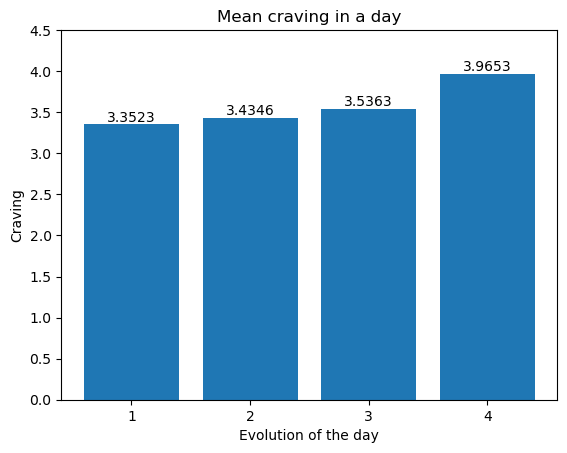

In [402]:
fig, ax = plt.subplots()
bar_container = ax.bar(df_by_SignalJour.index, df_by_SignalJour['Craving'])
ax.set(xlabel='Evolution of the day', ylabel='Craving', title='Mean craving in a day', ylim=(0, 4.5), xticks=[1, 2, 3, 4])
ax.bar_label(bar_container, fmt='{:,.4f}');

**Conclusion :** En moyenne, le craving est plus important en fin de journée et augmente au fur et à mesure de la journée.

**Question :** Est-ce que cette moyenne varie selon le sexe ?

In [403]:
df2 = data_raw[['SignalJour','Craving', 'Sexe']].copy()
df2 = df2.dropna()
df2.head()

SignalJour  Craving  Sexe
SubjectID                           
2004003             1      1.0     1
2004003             2      1.0     1
2004003             3      3.0     1
2004003             4      3.0     1
2004003             1      2.0     1

In [404]:
# On sépare le dataset selon 'Sexe'
df_sexe_0 = df2[df2['Sexe'] == 0]
df_sexe_1 = df2[df2['Sexe'] == 1]

In [405]:
# On groupe nos données par SignalJour
df_sexe_0_groupby = df_sexe_0.groupby(['SignalJour']).mean()
df_sexe_1_groupby = df_sexe_1.groupby(['SignalJour']).mean()

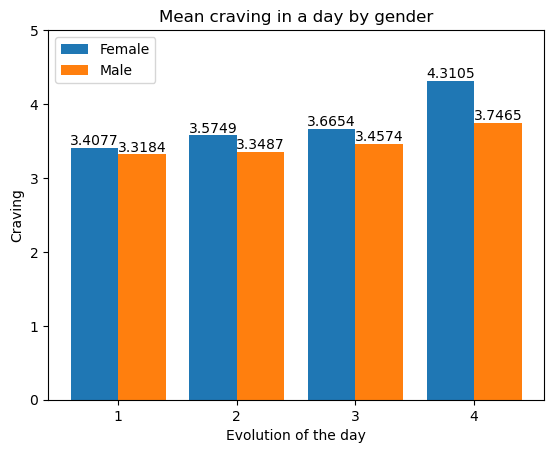

In [406]:
# Tracer les histogrammes côte à côte
fig, ax = plt.subplots()

# Tracer l'histogramme pour df_sexe_0_groupby
bar_container_0 = ax.bar(df_sexe_0_groupby.index - 0.2, df_sexe_0_groupby['Craving'], width=0.4, label='Female')

# Tracer l'histogramme pour df_sexe_1_groupby
bar_container_1 = ax.bar(df_sexe_1_groupby.index + 0.2, df_sexe_1_groupby['Craving'], width=0.4, label='Male')

ax.set(xlabel='Evolution of the day', ylabel='Craving', title='Mean craving in a day by gender', ylim=(0, 5), xticks=[1, 2, 3, 4])
ax.legend()
ax.bar_label(bar_container_0, fmt='{:,.4f}')
ax.bar_label(bar_container_1, fmt='{:,.4f}')

plt.show()

**Conclusion :** En moyenne, le craving est plus important chez les femmes et augmente au fur et à mesure de la journée.

**Question :** Est-ce que cette moyenne varie selon l'âge ?

In [360]:
df3 = data_raw[['SignalJour','Craving', 'Age']].copy()
df3 = df3.dropna()
df3.head()

SignalJour  Craving        Age
SubjectID                                
2004003             1      1.0  29.915068
2004003             2      1.0  29.915068
2004003             3      3.0  29.915068
2004003             4      3.0  29.915068
2004003             1      2.0  29.915068

Analysons la répartition de l'âge des patients dans l'étude :

In [361]:
mean_age = df3['Age'].mean()
mean_age

38.993401230706375

In [362]:
min_age = df3['Age'].min()
min_age

18.441095890411

In [363]:
max_age = df3['Age'].max()
max_age

64.5643835616438

Cherchons comment répartir les tranches d'âges :

In [364]:
sum_age = df3.groupby(['Age']).count()
sum_age = sum_age.drop(columns='Craving')

[Text(0.5, 0, 'Age'), Text(0, 0.5, 'Value'), Text(0.5, 1.0, 'Age repartition')]

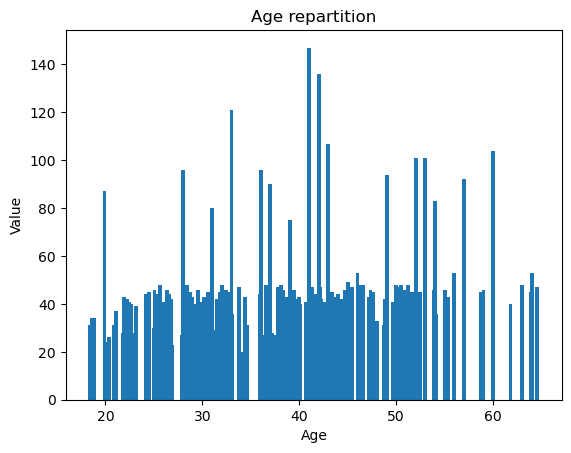

In [365]:
fig, ax = plt.subplots()
bar_container = ax.bar(sum_age.index, sum_age['SignalJour'], width=0.4)
ax.set(xlabel='Age', ylabel='Value', title='Age repartition')

In [366]:
# On crée des datasets pour les différentes tranches d'âge
df_age_18_25 = df3[(df3['Age'] > 18) & (df3['Age'] <= 25)]
df_age_25_50 = df3[(df3['Age'] > 25) & (df3['Age'] <= 50)]
df_age_50_65 = df3[(df3['Age'] > 50) & (df3['Age'] <= 65)]

In [367]:
# On groupe nos données par SignalJour
df_age_18_25 = df_age_18_25.groupby(['SignalJour']).mean()
df_age_25_50 = df_age_25_50.groupby(['SignalJour']).mean()
df_age_50_65 = df_age_50_65.groupby(['SignalJour']).mean()

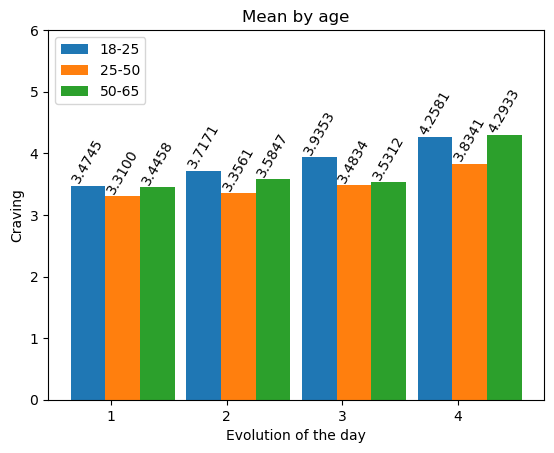

In [368]:
# Histogramme par tranches d'âge
fig, ax = plt.subplots()
bar_container_0 = ax.bar(df_age_18_25.index - 0.2, df_age_18_25['Craving'], width=0.3, label='18-25')
bar_container_1 = ax.bar(df_age_25_50.index + 0.1, df_age_25_50['Craving'], width=0.3, label='25-50')
bar_container_2 = ax.bar(df_age_50_65.index + 0.4, df_age_50_65['Craving'], width=0.3, label='50-65')

ax.set(xlabel='Evolution of the day', ylabel='Craving', title='Mean by age', ylim=(0, 6), xticks=[1, 2, 3, 4])
ax.legend(loc='upper left')
ax.bar_label(bar_container_0, fmt='{:,.4f}', rotation=60)
ax.bar_label(bar_container_1, fmt='{:,.4f}', rotation=60)
ax.bar_label(bar_container_2, fmt='{:,.4f}', rotation=60)

plt.show()

**Conclusion :** En moyenne, on remarque que les 18-25 ans et les 50-65 ans sont les plus sujets au craving.

**Question :** L'évolution du craving au cours de la journée est elle la même selon les type d'addiction ?

2 = Alcool<br>
5 = Opiacés<br>
9 = Stimulants<br>
10 = Cannabis<br>
17 = Tabac<br>

In [369]:
df4 = data_raw[['SignalJour','Craving', 'Addiction']].copy()
df4 = df4.dropna()
df4.head()

SignalJour  Craving  Addiction
SubjectID                                
2004003             1      1.0          5
2004003             2      1.0          5
2004003             3      3.0          5
2004003             4      3.0          5
2004003             1      2.0          5

In [370]:
# On sépare le dataset selon 'Addiction'
df_addict_2 = df4[df4['Addiction'] == 2]
df_addict_5 = df4[df4['Addiction'] == 5]
df_addict_9 = df4[df4['Addiction'] == 9]
df_addict_10 = df4[df4['Addiction'] == 10]
df_addict_17 = df4[df4['Addiction'] == 17]

In [371]:
# On groupe nos données par SignalJour
df_addict_2_groupby = df_addict_2.groupby(['SignalJour']).mean()
df_addict_5_groupby = df_addict_5.groupby(['SignalJour']).mean()
df_addict_9_groupby = df_addict_9.groupby(['SignalJour']).mean()
df_addict_10_groupby = df_addict_10.groupby(['SignalJour']).mean()
df_addict_17_groupby = df_addict_17.groupby(['SignalJour']).mean()

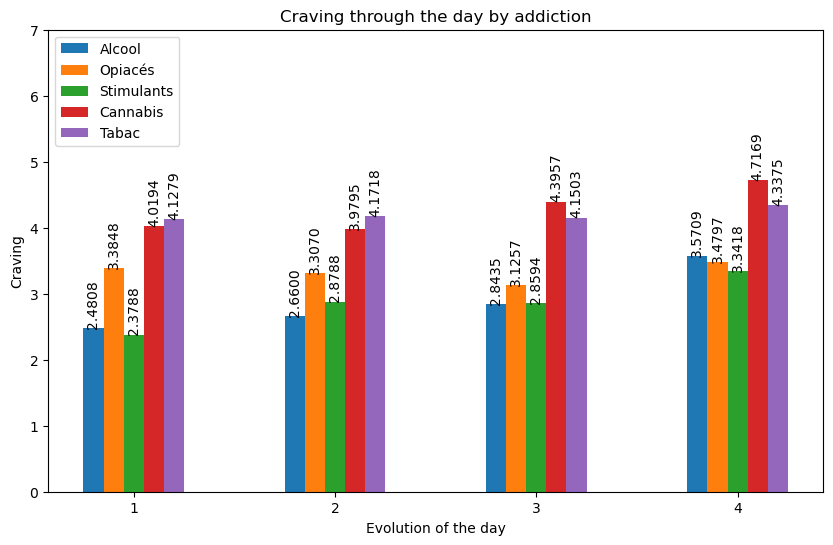

In [372]:
# Histogramme par type d'addiction
fig, ax = plt.subplots(figsize=(10, 6))
bar_container_0 = ax.bar(df_addict_2_groupby.index - 0.2, df_addict_2_groupby['Craving'], width=0.1, label='Alcool')
bar_container_1 = ax.bar(df_addict_5_groupby.index - 0.1, df_addict_5_groupby['Craving'], width=0.1, label='Opiacés')
bar_container_2 = ax.bar(df_addict_9_groupby.index + 0.0, df_addict_9_groupby['Craving'], width=0.1, label='Stimulants')
bar_container_3 = ax.bar(df_addict_10_groupby.index + 0.1, df_addict_10_groupby['Craving'], width=0.1, label='Cannabis')
bar_container_4 = ax.bar(df_addict_17_groupby.index + 0.2, df_addict_17_groupby['Craving'], width=0.1, label='Tabac')

ax.set(xlabel='Evolution of the day', ylabel='Craving', title='Craving through the day by addiction', ylim=(0, 7), xticks=[1, 2, 3, 4])
ax.legend(loc='upper left')
ax.bar_label(bar_container_0, fmt='{:,.4f}', rotation=90)
ax.bar_label(bar_container_1, fmt='{:,.4f}', rotation=90)
ax.bar_label(bar_container_2, fmt='{:,.4f}', rotation=90)
ax.bar_label(bar_container_3, fmt='{:,.4f}', rotation=90)
ax.bar_label(bar_container_4, fmt='{:,.4f}', rotation=90)

plt.show()

**Conclusion :** En moyenne, on remarque que le cannabis et le tabac sont les substances provoquant le plus de craving.

**Question :** Est-ce que la prise d'un traitement atténue le craving ?

In [373]:
df5 = data_raw[['SignalJour','Craving', 'Addict_Treat']].copy()
df5 = df5.dropna()
df5.head()

SignalJour  Craving  Addict_Treat
SubjectID                                   
2004003             1      1.0           0.0
2004003             2      1.0           1.0
2004003             3      3.0           0.0
2004003             4      3.0           0.0
2004003             1      2.0           0.0

In [374]:
# On sépare le dataset selon si prise de traitement
df_traitement_0 = df5[df5['Addict_Treat'] == 0]
df_traitement_1 = df5[df5['Addict_Treat'] == 1]

In [375]:
# On groupe nos données par SignalJour
df_traitement_0_groupby = df_traitement_0.groupby(['SignalJour']).mean()
df_traitement_1_groupby = df_traitement_1.groupby(['SignalJour']).mean()

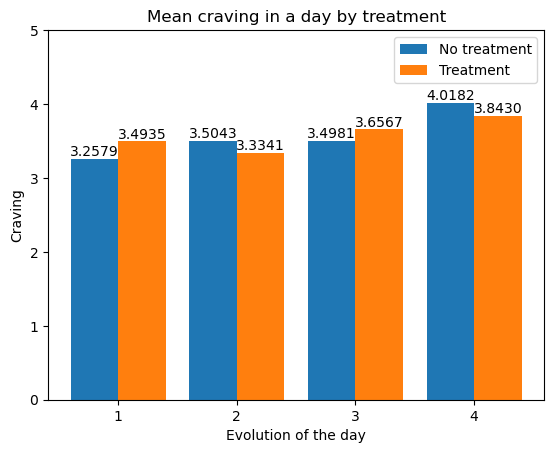

In [376]:
fig, ax = plt.subplots()

bar_container_0 = ax.bar(df_traitement_0_groupby.index - 0.2, df_traitement_0_groupby['Craving'], width=0.4, label='No treatment')
bar_container_1 = ax.bar(df_traitement_1_groupby.index + 0.2, df_traitement_1_groupby['Craving'], width=0.4, label='Treatment')

ax.set(xlabel='Evolution of the day', ylabel='Craving', title='Mean craving in a day by treatment', ylim=(0, 5), xticks=[1, 2, 3, 4])
ax.legend()
ax.bar_label(bar_container_0, fmt='{:,.4f}')
ax.bar_label(bar_container_1, fmt='{:,.4f}')

plt.show()

**Conclusion :** Les valeurs avec traitement sont sensiblement proches des valeurs sans traitement. On retrouve également l'augmentation du craving en fin de journée. On a juste une différence pour la valeur de début de journée, celle-ci est plus élevée que pour les patients ne prenant pas de traitement.

# Analyse par semaine

**Question :** Quelle est l'évolution moyenne du craving sur une 2 semaines ?

In [377]:
df6 = data_raw[['SignalJour','Craving', 'NumJour']].copy()
df6 = df6.dropna()
df6.head()

SignalJour  Craving  NumJour
SubjectID                              
2004003             1      1.0        2
2004003             2      1.0        2
2004003             3      3.0        2
2004003             4      3.0        2
2004003             1      2.0        3

In [378]:
df_week_groupby = df6.groupby(['NumJour']).mean()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


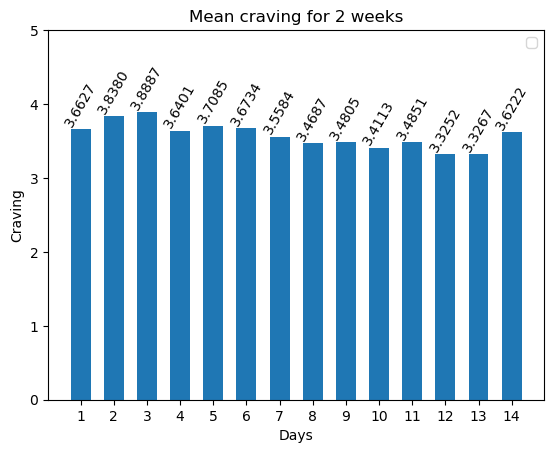

In [379]:
fig, ax = plt.subplots()

bar_container_0 = ax.bar(df_week_groupby.index - 0, df_week_groupby['Craving'], width=0.6)

ax.set(xlabel='Days', ylabel='Craving', title='Mean craving for 2 weeks', ylim=(0, 5), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
ax.legend()
ax.bar_label(bar_container_0, fmt='{:,.4f}', rotation=60)

plt.show()

In [380]:
df_week_1 = df6[(df6['NumJour'] > 0) & (df6['NumJour'] <= 7)]
df_week_2 = df6[(df6['NumJour'] > 7) & (df6['NumJour'] <= 15)]

In [381]:
df_week_1_groupby = df_week_1.groupby(['NumJour']).mean()
df_week_2_groupby = df_week_2.groupby(['NumJour']).mean()

In [382]:
df_week_1_groupby.reset_index(inplace=True)
df_week_2_groupby.reset_index(inplace=True)

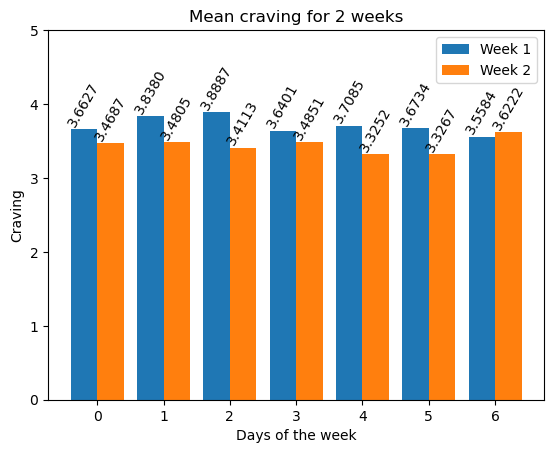

In [383]:
fig, ax = plt.subplots()

bar_container_0 = ax.bar(df_week_1_groupby.index - 0.2, df_week_1_groupby['Craving'], width=0.4, label='Week 1')
bar_container_1 = ax.bar(df_week_2_groupby.index + 0.2, df_week_2_groupby['Craving'], width=0.4, label='Week 2')

ax.set(xlabel='Days of the week', ylabel='Craving', title='Mean craving for 2 weeks', ylim=(0, 5))
ax.legend()
ax.bar_label(bar_container_0, fmt='{:,.4f}', rotation=60)
ax.bar_label(bar_container_1, fmt='{:,.4f}', rotation=60)

plt.show()

**Conclusion :** En moyenne, les patients on ressenti moins de manque la deuxième semaine. Les évaluations ayant commencées lors de l'arrivée des patients en hôpital, on peut donc supposer que cette hospitalisation est bénéfique concernant ce symptôme.

**Question :** Quelle serait la prédiction pour la 3e semaine ?

## Prédictions des valeurs pour la 3e semaine

### Prédiction pour 1 patient

In [384]:
df_week3 = data_raw[['NumJour', 'Craving', ]].copy()
df_week3 = df_week3.dropna()
#df_week3

In [385]:
#Séparation des données par patient (ex : result['2004003'])

# On défini l'index au numéro de patient
result = {}

for subject_id, data in df_week3.groupby('SubjectID'):
    result[f'{subject_id}'] = data
    
list_patients = result.keys()
#list_patients

In [386]:
# On selectionne un patient
patient = '2022071'
df_patient = result[patient]

# On fait un group by jours pour ramener les valeurs sur 14 jours
df_patient_groupby_jour = df_patient.groupby('NumJour').mean()
#df_patient_groupby_jour

In [387]:
# On rajoute une colonne en format date pour la prédiction dans le temps
start_date = pd.to_datetime('2023-01-01')
df_patient_groupby_jour['ds'] = start_date + pd.to_timedelta(df_patient_groupby_jour.index - 1, unit='D')
df_patient_groupby_jour = df_patient_groupby_jour.rename(columns={'Craving': 'y'})
df_patient_groupby_jour

y         ds
NumJour                     
1        2.250000 2023-01-01
2        2.250000 2023-01-02
3        2.000000 2023-01-03
4        2.250000 2023-01-04
5        3.250000 2023-01-05
6        4.000000 2023-01-06
7        3.666667 2023-01-07
8        3.000000 2023-01-08
9        3.750000 2023-01-09
10       3.250000 2023-01-10
11       4.750000 2023-01-11
12       4.750000 2023-01-12
13       5.000000 2023-01-13
14       4.250000 2023-01-14

In [388]:
df_patient_groupby_jour['cap'] = 8

In [390]:
m = Prophet(growth='logistic', 
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=True)
m.fit(df_patient_groupby_jour)

22:57:57 - cmdstanpy - INFO - Chain [1] start processing
22:57:57 - cmdstanpy - INFO - Chain [1] done processing


ds  cap
0 2023-01-15    8
1 2023-01-16    8
2 2023-01-17    8
3 2023-01-18    8
4 2023-01-19    8
5 2023-01-20    8
6 2023-01-21    8

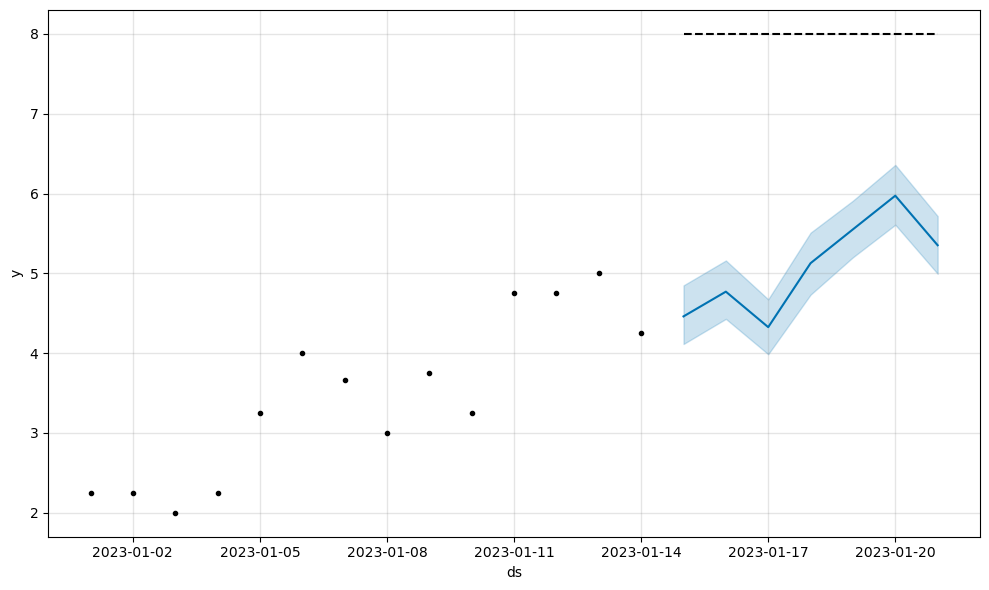

In [393]:
future = m.make_future_dataframe(periods=7, freq='D', include_history=False)
future['cap'] = 8
fcst = m.predict(future)
fig = m.plot(fcst)
future

### Généralisation à tous les patients et extraction des plots

In [397]:
for patient in list(list_patients):
    
    df_patient = result[patient]
    
    # On fait un group by jours pour ramener les valeurs sur 14 jours
    df_patient_groupby_jour = df_patient.groupby('NumJour').mean()
    
    # On rajoute une colonne en format date pour la prédiction dans le temps
    start_date = pd.to_datetime('2023-01-01')
    df_patient_groupby_jour['ds'] = start_date + pd.to_timedelta(df_patient_groupby_jour.index - 1, unit='D')
    df_patient_groupby_jour = df_patient_groupby_jour.rename(columns={'Craving': 'y'})
    
    df_patient_groupby_jour['cap'] = 8
    m = Prophet(growth='logistic', 
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=True)
    m.fit(df_patient_groupby_jour)
    
    future = m.make_future_dataframe(periods=7, freq='D', include_history=False)
    future['cap'] = 8
    fcst = m.predict(future)
    fig = m.plot(fcst)
    
    plt.savefig(f'./plots/predict_week3/{patient}.png')
    plt.close()

23:22:54 - cmdstanpy - INFO - Chain [1] start processing
23:22:54 - cmdstanpy - INFO - Chain [1] done processing
23:22:54 - cmdstanpy - INFO - Chain [1] start processing
23:22:54 - cmdstanpy - INFO - Chain [1] done processing
23:22:54 - cmdstanpy - INFO - Chain [1] start processing
23:22:55 - cmdstanpy - INFO - Chain [1] done processing
23:22:55 - cmdstanpy - INFO - Chain [1] start processing
23:22:55 - cmdstanpy - INFO - Chain [1] done processing
23:22:55 - cmdstanpy - INFO - Chain [1] start processing
23:22:55 - cmdstanpy - INFO - Chain [1] done processing
23:22:55 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:57 - cmdstanpy - INFO - Chain [1] start processing
23:22:57 - cmdstanpy - INFO - Chain [1]

23:23:42 - cmdstanpy - INFO - Chain [1] done processing
23:23:42 - cmdstanpy - INFO - Chain [1] start processing
23:23:42 - cmdstanpy - INFO - Chain [1] done processing
23:23:42 - cmdstanpy - INFO - Chain [1] start processing
23:23:42 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:44 - cmdstanpy - INFO - Chain [1] done processing
23:23:44 - cmdstanpy - INFO - Chain [1] start processing
23:23:44 - cmdstanpy - INFO - Chain [1] done processing
23:23:44 - cmdstanpy - INFO - Chain [1] start processing
23:23:44 - cmdstanpy - INFO - Chain [1] done processing
23:23:44 - cmdstanpy - INFO - Chain [1] start processing
23:23:45 - cmdstanpy - INFO - Chain [1] done processing
23:23:45 - cmdstanpy - INFO - Chain [1] 

23:24:17 - cmdstanpy - INFO - Chain [1] done processing
23:24:17 - cmdstanpy - INFO - Chain [1] start processing
23:24:17 - cmdstanpy - INFO - Chain [1] done processing
23:24:17 - cmdstanpy - INFO - Chain [1] start processing
23:24:17 - cmdstanpy - INFO - Chain [1] done processing
23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing
23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing
23:24:19 - cmdstanpy - INFO - Chain [1] start processing
23:24:19 - cmdstanpy - INFO - Chain [1] done processing
23:24:19 - cmdstanpy - INFO - Chain [1] start processing
23:24:19 - cmdstanpy - INFO - Chain [1] done processing
23:24:20 - cmdstanpy - INFO - Chain [1] start processing
23:24:20 - cmdstanpy - INFO - Chain [1] done processing
23:24:20 - cmdstanpy - INFO - Chain [1] start processing
23:24:20 - cmdstanpy - INFO - Chain [1] done processing
23:24:20 - cmdstanpy - INFO - Chain [1] 

# Analyse saisonalité jounalière

## Individuel

In [191]:
df7 = data_raw[['SignalJour', 'NumJour', 'Craving', ]].copy()
df7 = df7.dropna()
df7

SignalJour  NumJour  Craving
SubjectID                              
2004003             1        2      1.0
2004003             2        2      1.0
2004003             3        2      3.0
2004003             4        2      3.0
2004003             1        3      2.0
...               ...      ...      ...
6402002             4       13      3.0
6402002             1       14      2.0
6402002             2       14      3.0
6402002             3       14      2.0
6402002             4       14      3.0

[8584 rows x 3 columns]

In [192]:
#Séparation des données par patient (ex : result['2004003'])

# On défini l'index au numéro de patient
result = {}

for subject_id, data in df7.groupby('SubjectID'):
    result[f'{subject_id}'] = data

In [193]:
list_patients = result.keys()
#list_patients

#### Exemple pour 1 patient :

In [194]:
# On selectionne un patient
patient = '2022071'
df_patient = result[patient]
#df_patient

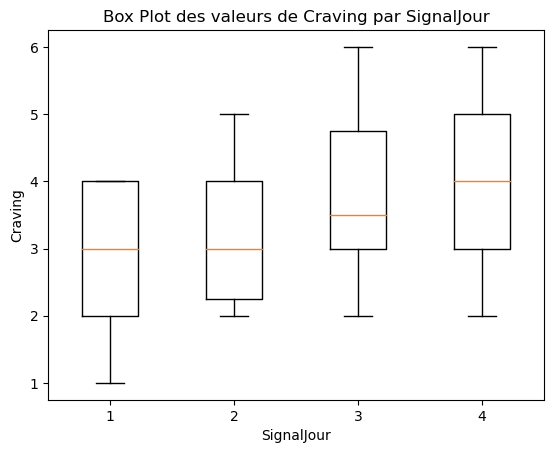

In [195]:
# Votre DataFrame df_patient_groupby
data = df_patient

df = pd.DataFrame(data)

# Créer un box plot
plt.boxplot([df[df['SignalJour'] == signal_jour]['Craving'] for signal_jour in sorted(df['SignalJour'].unique())],
            labels=sorted(df['SignalJour'].unique()))
plt.xlabel('SignalJour')
plt.ylabel('Craving')
plt.title('Box Plot des valeurs de Craving par SignalJour')
plt.show()

/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



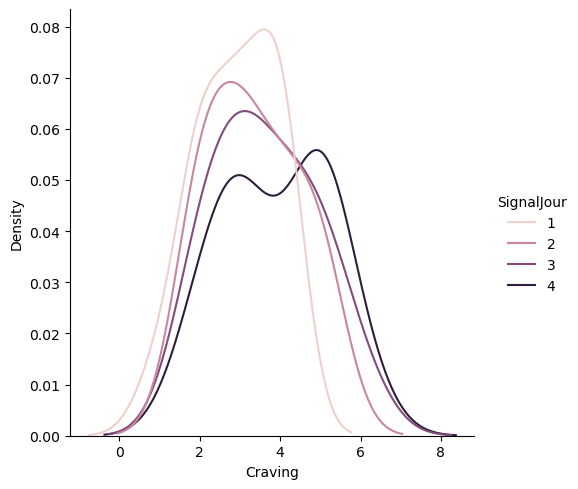

In [196]:
sns.displot(data=df_patient, x="Craving", hue="SignalJour", kind="kde")

**Conclusion :** On remarque qu'il y a un schéma réccurent de jour en jour, différents pour chaque individus. C'est-à-dire que les patients indiquent des valeurs de craving homogènes selon le moment (SignalJour : 1, 2, 3, 4). Ceci est mis en évidence par la faible variance dans les boxplots.

### Pour tous les patients

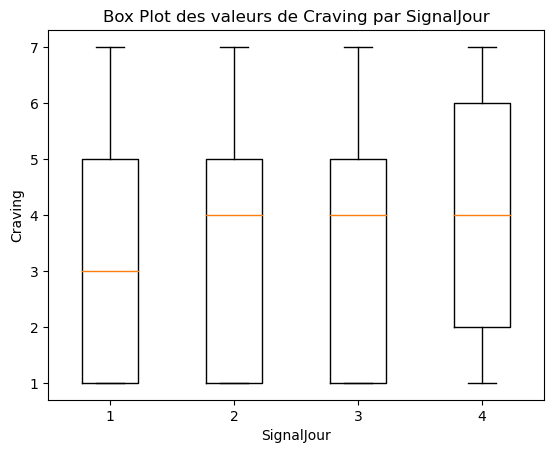

In [197]:
# Votre DataFrame df_patient_groupby
data = df7

df = pd.DataFrame(data)

# Créer un box plot
plt.boxplot([df[df['SignalJour'] == signal_jour]['Craving'] for signal_jour in sorted(df['SignalJour'].unique())],
            labels=sorted(df['SignalJour'].unique()))
plt.xlabel('SignalJour')
plt.ylabel('Craving')
plt.title('Box Plot des valeurs de Craving par SignalJour')
plt.show()

/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



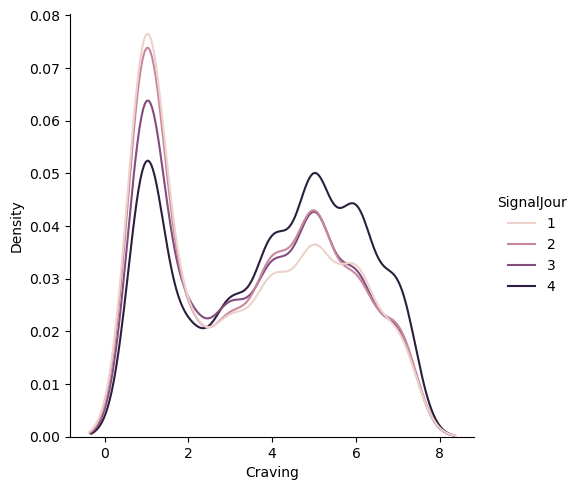

In [198]:
sns.displot(data=df7, x="Craving", hue="SignalJour", kind="kde")

### Analyse globale de la dynamique par moment de la journée :

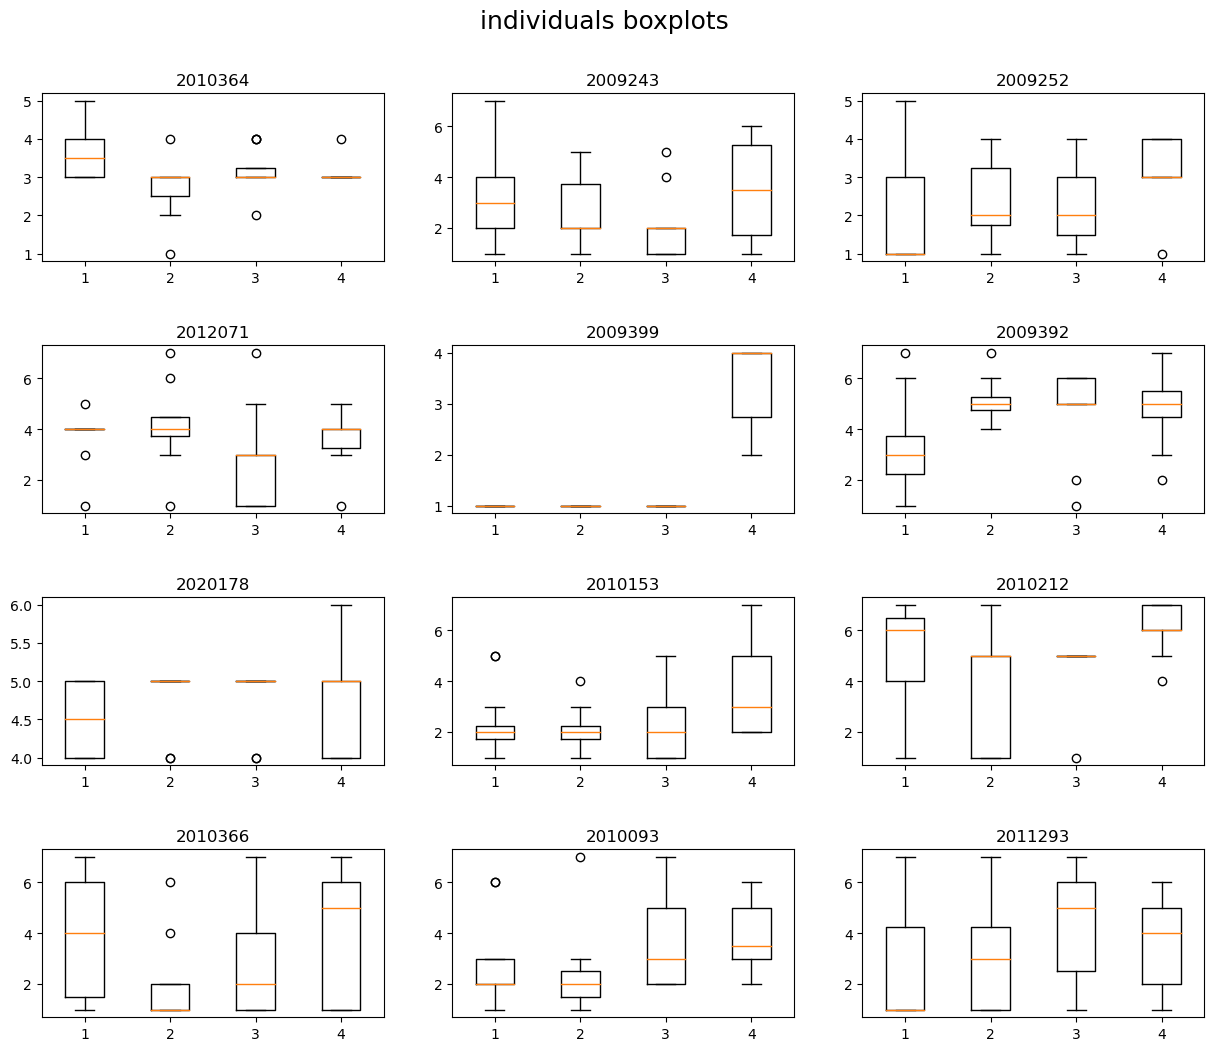

In [199]:
sub_list = random.sample(list(result.keys()), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['SignalJour'] == signal_jour]['Craving'] for signal_jour in sorted(df['SignalJour'].unique())],
            labels=sorted(df['SignalJour'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()

**Conclusion :** On remarque que chaque patient à une dynamique de craving différente même si on retrouve des profils similaires entre certains patients. 
Sur la saisonalité, on remarque une certaine réccurence des valeurs du craving données par le patient suivant les moments de la journée (exemple : le patient répond toujours 2 pour le moment 1). Même si, comme vu plus haut, on observe que le craving à tendance à croitre progressivement au cours de journée avec une augmentation plus forte en fin de journée (en moyenne).

# Analyse saisonalité hebdomadaire

In [200]:
# On selectionne un patient
df_patient = result['2022071']
df_patient['NumJourHarmonise'] = df_patient['NumJour'] % 8 + df_patient['NumJour'] // 8
#df_patient

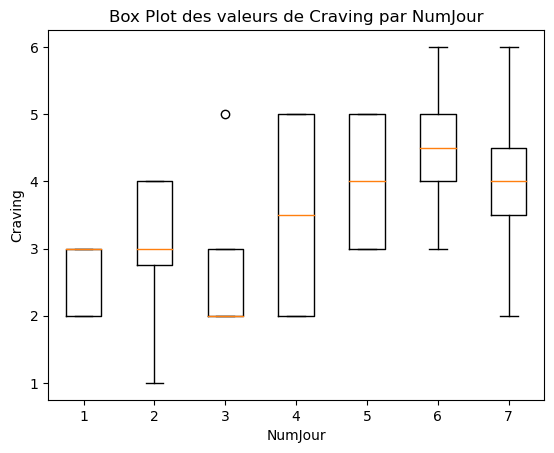

In [201]:
# Votre DataFrame df_patient_groupby
data = df_patient

df = pd.DataFrame(data)

# Créer un box plot
plt.boxplot([df[df['NumJourHarmonise'] == signal_jour]['Craving'] for signal_jour in sorted(df['NumJourHarmonise'].unique())],
            labels=sorted(df['NumJourHarmonise'].unique()))
plt.xlabel('NumJour')
plt.ylabel('Craving')
plt.title('Box Plot des valeurs de Craving par NumJour')
plt.show()

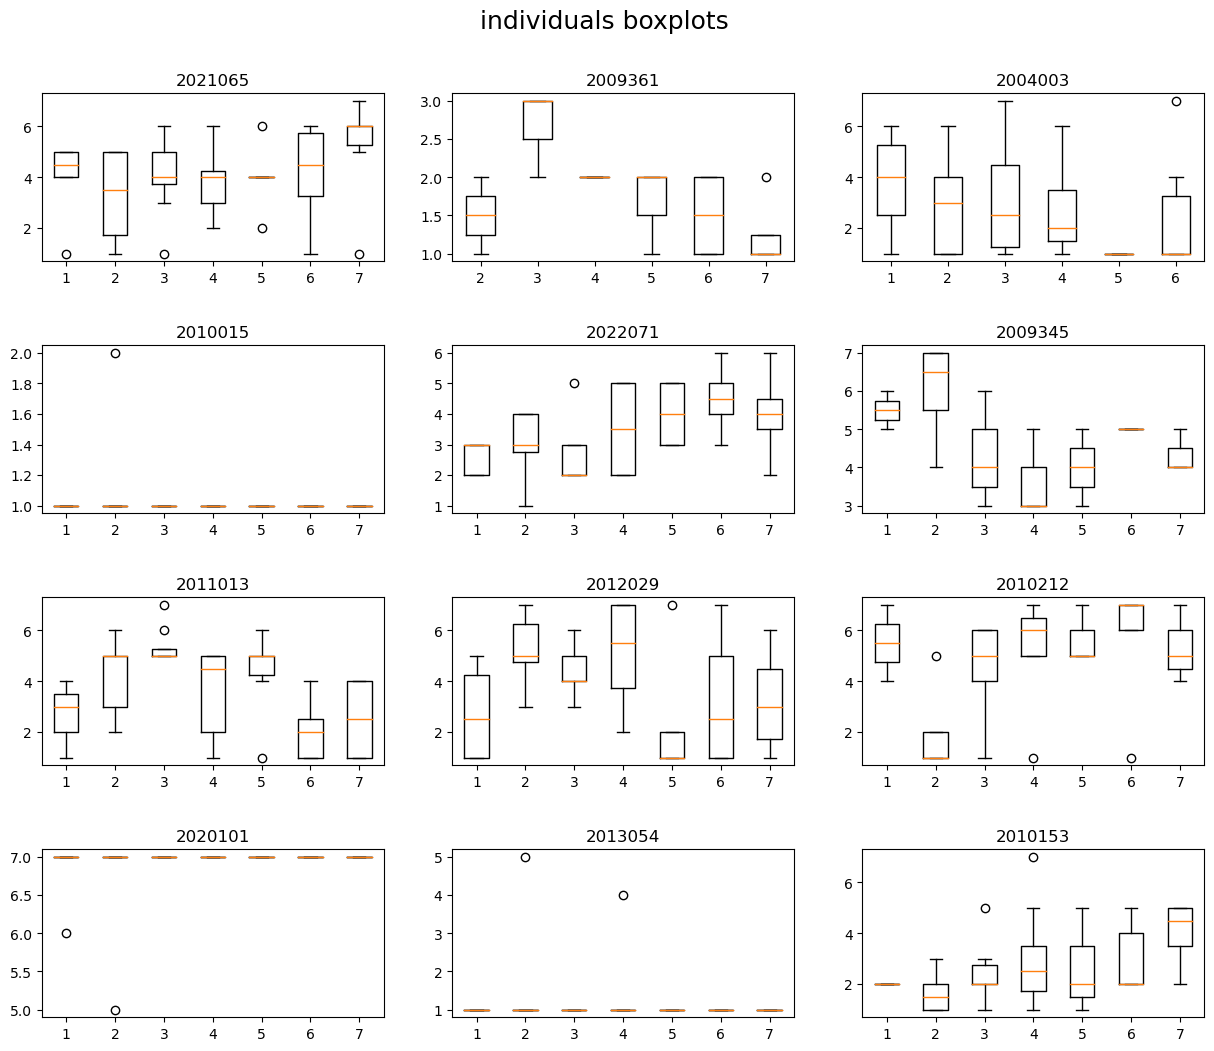

In [202]:
sub_list = random.sample(list(result.keys()), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df_patient['NumJourHarmonise'] = df_patient['NumJour'] % 8 + df_patient['NumJour'] // 8
    
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['NumJourHarmonise'] == signal_jour]['Craving'] for signal_jour in sorted(df['NumJourHarmonise'].unique())],
            labels=sorted(df['NumJourHarmonise'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()

**Conclusion :** Par semaines, on remarque que chaque paque patient présente un schéma spécifique de manière similaire à l'analyse journalière. Maintenant, on peut se demander quels sont les différents types de profils des patients.

# Clustering

On crée un dataset pour le clustering :

In [203]:
df_clustering = pd.DataFrame(index=list_patients, columns=['1', '2', '3', '4'])
df_clustering

1    2    3    4
2004003  NaN  NaN  NaN  NaN
2007006  NaN  NaN  NaN  NaN
2008254  NaN  NaN  NaN  NaN
2008275  NaN  NaN  NaN  NaN
2009144  NaN  NaN  NaN  NaN
...      ...  ...  ...  ...
2022061  NaN  NaN  NaN  NaN
2022071  NaN  NaN  NaN  NaN
2022073  NaN  NaN  NaN  NaN
2022075  NaN  NaN  NaN  NaN
6402002  NaN  NaN  NaN  NaN

[211 rows x 4 columns]

In [204]:
for patient in list_patients:
    df_patient = result[patient]
    df_patient_groupby = df_patient.groupby(['SignalJour']).mean()
    df_clustering.loc[patient, :] = df_patient_groupby['Craving'].values
df_clustering

1         2         3         4
2004003     1.875  1.545455  3.444444     3.875
2007006       1.0       2.0  1.333333  1.916667
2008254       6.0     5.125     5.125  6.181818
2008275  2.166667  2.454545  2.916667       2.4
2009144  1.909091  3.166667      3.75  4.666667
...           ...       ...       ...       ...
2022061  1.666667       1.8  1.777778  1.777778
2022071  2.928571  3.357143  3.642857  3.923077
2022073       5.5  4.857143  4.416667  3.833333
2022075  5.555556  6.615385  5.818182  6.307692
6402002  2.916667  3.416667  3.777778     3.125

[211 rows x 4 columns]

## 1. K-Means

In [205]:
df_kmeans = df_clustering
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_kmeans)
    distortions.append(kmeanModel.inertia_)

/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/mathildeoukaci/anaconda3/lib/pyth

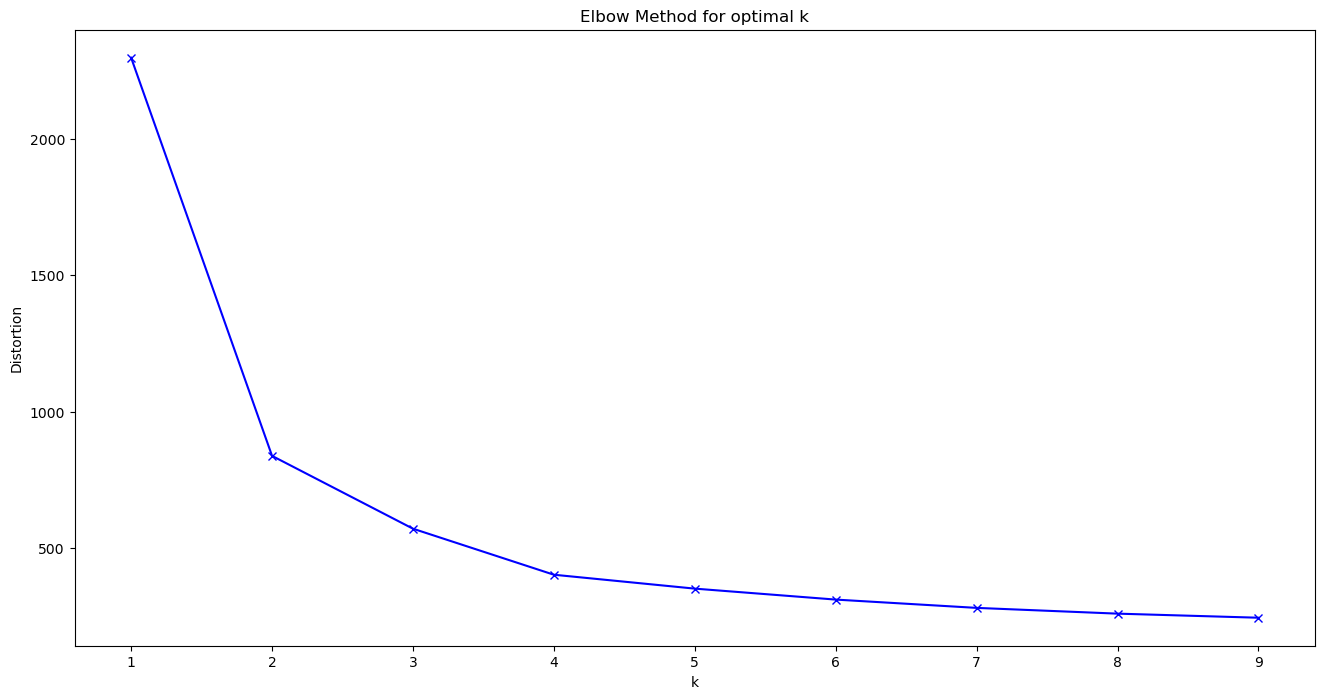

In [206]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



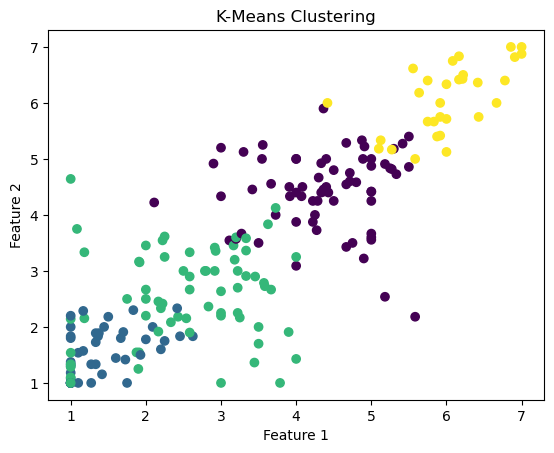

In [207]:
df_kmeans = df_clustering

# Nombre de clusters que vous voulez créer
num_clusters = 4

# Créer le modèle K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuster le modèle aux données
kmeans.fit(df_kmeans)

# Obtenir les étiquettes de cluster pour chaque patient
df_kmeans['Cluster'] = kmeans.labels_

# Afficher les résultats
#print(df_kmeans[['Cluster']])

# Visualiser le résultat (2D, en utilisant les deux premières colonnes du dataset)
plt.scatter(df_kmeans['1'], df_kmeans['2'], c=df_kmeans['Cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



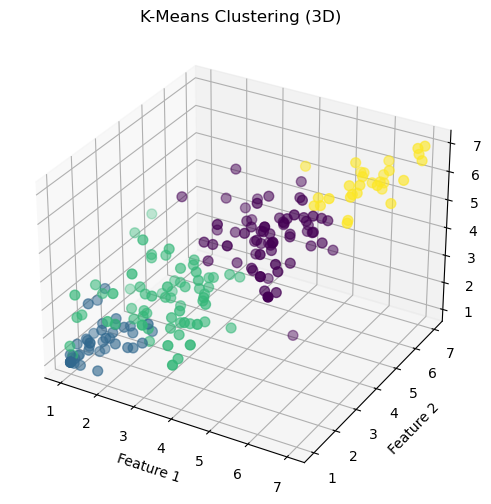

In [208]:
from mpl_toolkits.mplot3d import Axes3D  # Importer cette classe pour la visualisation en 3D

df_kmeans = df_clustering

# Nombre de clusters que vous voulez créer
num_clusters = 4

# Créer le modèle K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuster le modèle aux données
kmeans.fit(df_kmeans)

# Obtenir les étiquettes de cluster pour chaque patient
df_kmeans['Cluster'] = kmeans.labels_

# Visualiser le résultat en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_kmeans['1'], df_kmeans['2'], df_kmeans['3'], c=df_kmeans['Cluster'], cmap='viridis', s=50)
ax.set_title('K-Means Clustering (3D)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

plt.show()


In [209]:
import plotly.express as px

df_kmeans = df_clustering

# Nombre de clusters que vous voulez créer
num_clusters = 4

# Créer le modèle K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuster le modèle aux données
kmeans.fit(df_kmeans)

# Obtenir les étiquettes de cluster pour chaque patient
df_kmeans['Cluster'] = kmeans.labels_

# Utiliser Plotly pour la visualisation en 3D
fig = px.scatter_3d(df_kmeans, x='1', y='2', z='3', color='Cluster', size_max=18, opacity=0.8,
                    title='K-Means Clustering (3D)', labels={'1': 'Feature 1', '2': 'Feature 2', '3': 'Feature 3'})
fig.show()


/Users/mathildeoukaci/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [210]:
df_kmeans_G0 = df_kmeans[df_kmeans['Cluster'] == 0]
list_kmeans_G0 = df_kmeans_G0.index
list_kmeans_G0

Index(['2009152', '2009162', '2009189', '2009198', '2009207', '2009208',
       '2009222', '2009239', '2009241', '2009250', '2009297', '2009303',
       '2009326', '2009342', '2009345', '2009349', '2009381', '2009390',
       '2009392', '2010024', '2010031', '2010039', '2010047', '2010077',
       '2010204', '2010212', '2010242', '2010300', '2010316', '2010321',
       '2010329', '2011013', '2011027', '2011032', '2011068', '2011133',
       '2011169', '2011201', '2011307', '2012029', '2012054', '2012061',
       '2012114', '2012151', '2012152', '2012165', '2012356', '2013084',
       '2013100', '2013200', '2013221', '2013259', '2018296', '2019314',
       '2020036', '2020085', '2020178', '2020193', '2021065', '2021066',
       '2021084', '2021096', '2021107', '2021115', '2021142', '2021151',
       '2022053', '2022073'],
      dtype='object')

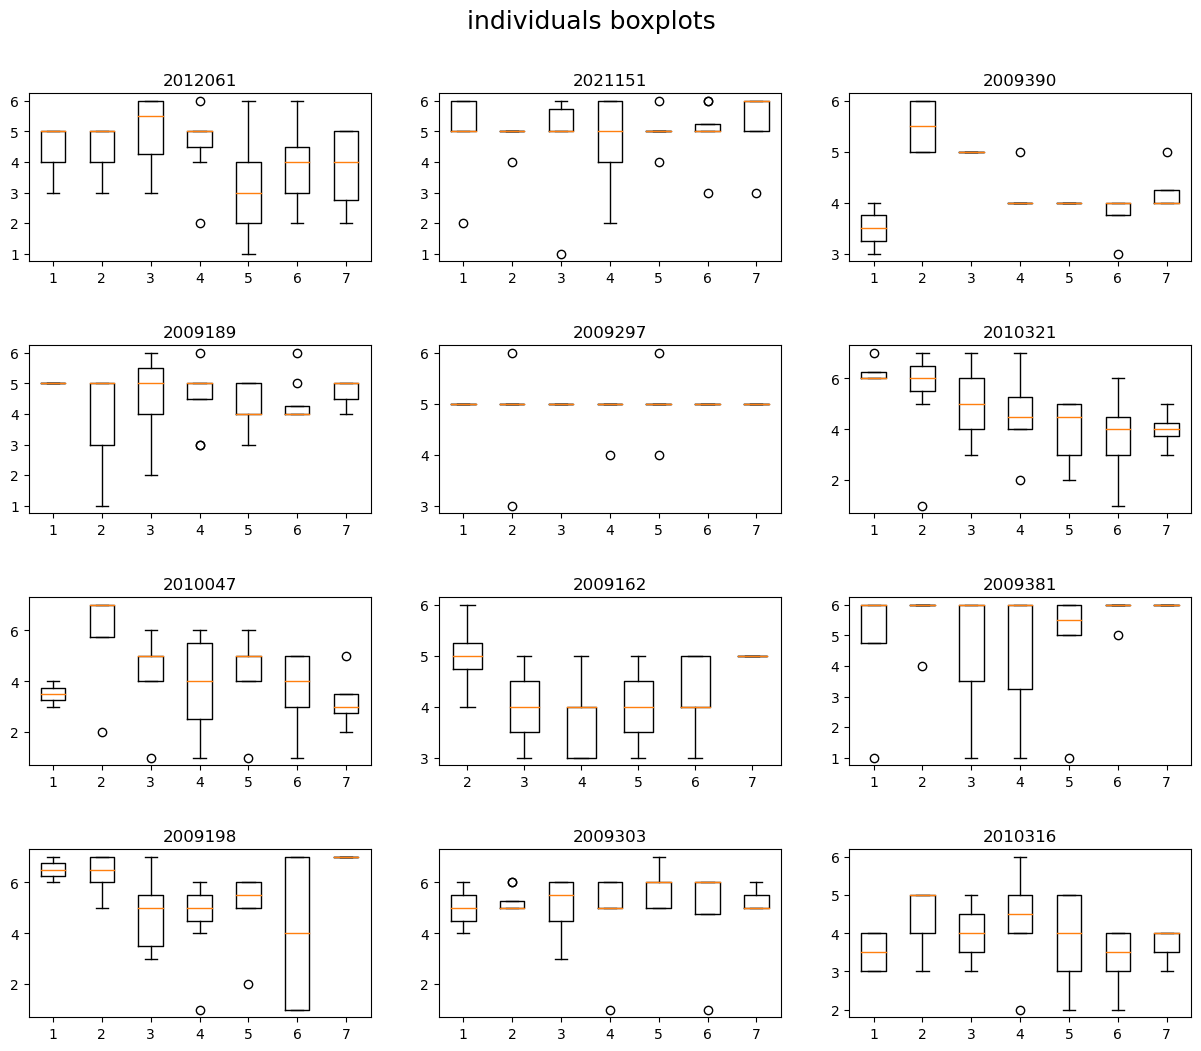

In [211]:
sub_list = random.sample(list(list_kmeans_G0), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df_patient['NumJourHarmonise'] = df_patient['NumJour'] % 8 + df_patient['NumJour'] // 8
    
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['NumJourHarmonise'] == signal_jour]['Craving'] for signal_jour in sorted(df['NumJourHarmonise'].unique())],
            labels=sorted(df['NumJourHarmonise'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()

In [212]:
df_kmeans_G1 = df_kmeans[df_kmeans['Cluster'] == 1]
list_kmeans_G1 = df_kmeans_G1.index
list_kmeans_G1

Index(['2007006', '2009155', '2009195', '2009221', '2009231', '2009232',
       '2009253', '2009266', '2009296', '2009304', '2009318', '2009335',
       '2009361', '2009382', '2009399', '2010012', '2010015', '2010048',
       '2010055', '2010071', '2010099', '2010140', '2010149', '2010218',
       '2010225', '2010274', '2010277', '2010314', '2011005', '2011011',
       '2011103', '2011153', '2011167', '2011217', '2012028', '2012078',
       '2013054', '2020046', '2021041', '2021047', '2021143', '2021166',
       '2022027', '2022047', '2022061'],
      dtype='object')

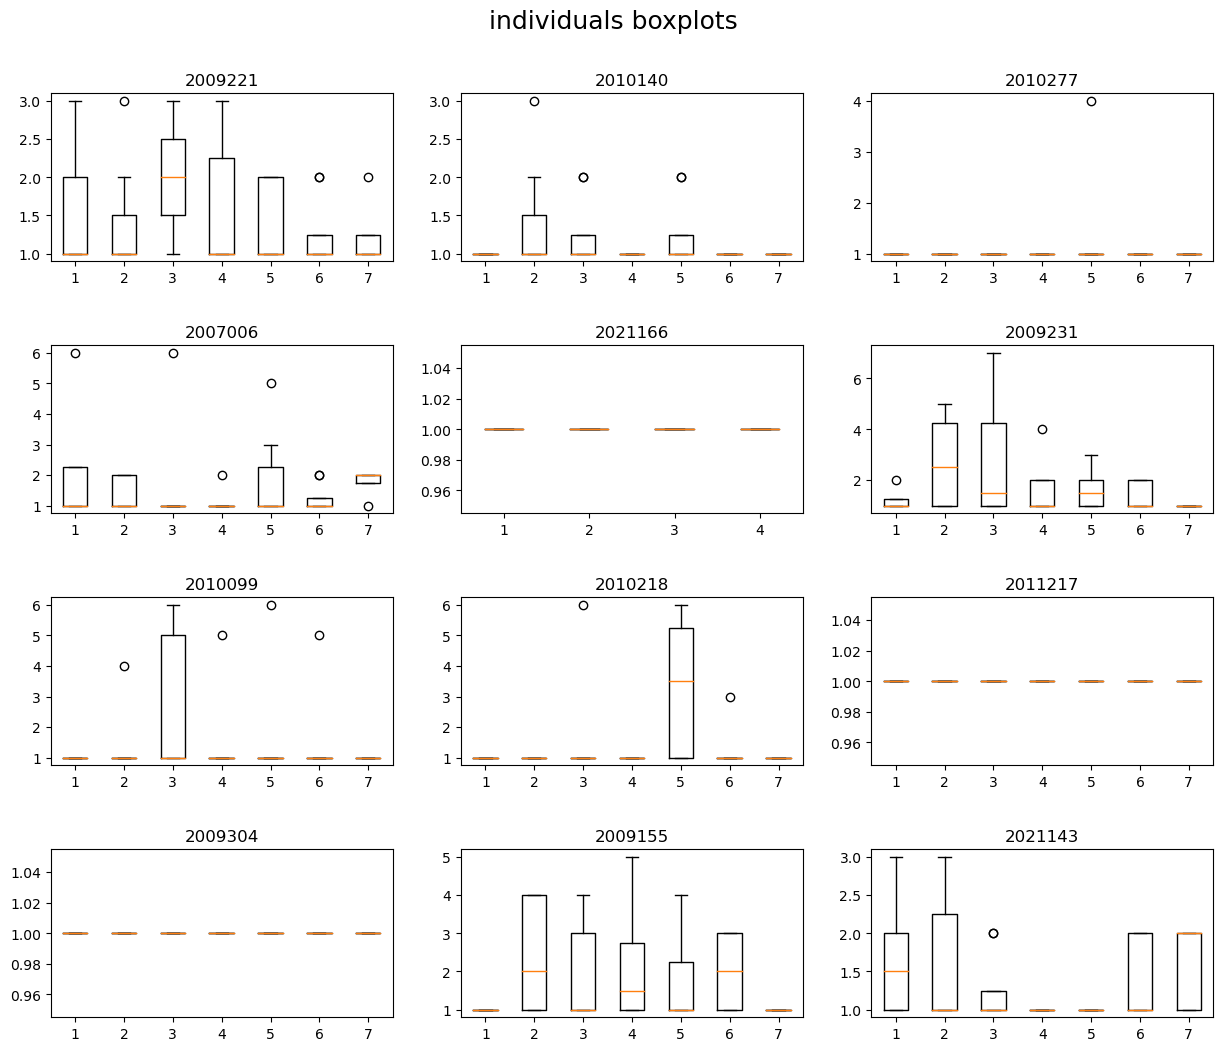

In [213]:
sub_list = random.sample(list(list_kmeans_G1), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df_patient['NumJourHarmonise'] = df_patient['NumJour'] % 8 + df_patient['NumJour'] // 8
    
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['NumJourHarmonise'] == signal_jour]['Craving'] for signal_jour in sorted(df['NumJourHarmonise'].unique())],
            labels=sorted(df['NumJourHarmonise'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()

In [214]:
df_kmeans_G2 = df_kmeans[df_kmeans['Cluster'] == 2]
list_kmeans_G2 = df_kmeans_G2.index
list_kmeans_G2

Index(['2004003', '2008275', '2009144', '2009200', '2009243', '2009252',
       '2009283', '2009300', '2009309', '2009311', '2009323', '2009324',
       '2009325', '2009388', '2010067', '2010093', '2010151', '2010152',
       '2010153', '2010158', '2010193', '2010239', '2010240', '2010257',
       '2010264', '2010275', '2010292', '2010294', '2010322', '2010361',
       '2010364', '2010366', '2011014', '2011018', '2011101', '2011104',
       '2011138', '2011203', '2011208', '2011250', '2011279', '2011287',
       '2011293', '2012018', '2012066', '2012071', '2012083', '2012110',
       '2012268', '2013146', '2019298', '2019320', '2019326', '2020091',
       '2020141', '2020209', '2021010', '2021145', '2021152', '2021159',
       '2021168', '2021173', '2021193', '2022016', '2022038', '2022051',
       '2022071', '6402002'],
      dtype='object')

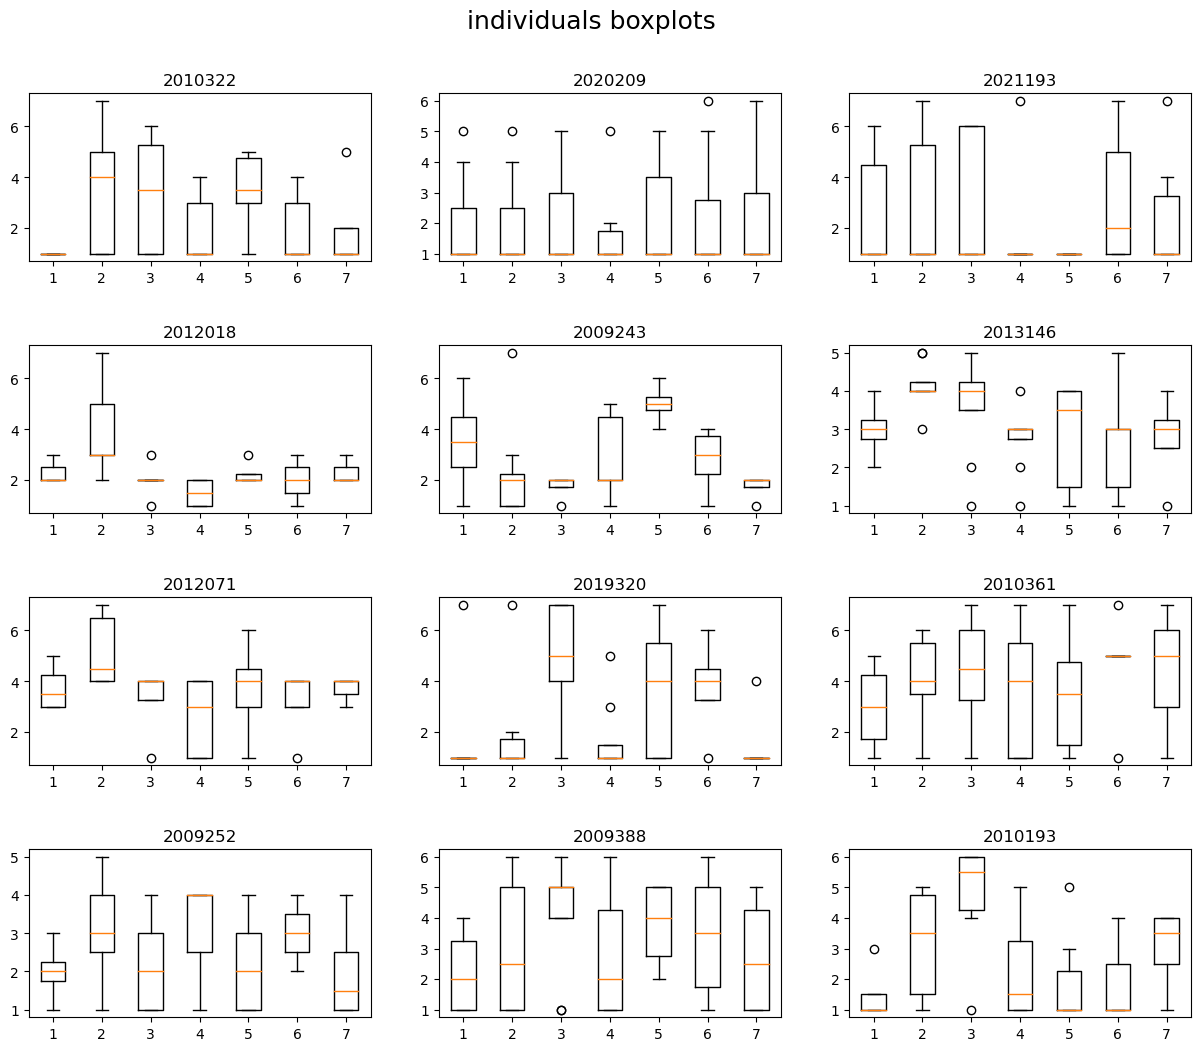

In [215]:
sub_list = random.sample(list(list_kmeans_G2), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df_patient['NumJourHarmonise'] = df_patient['NumJour'] % 8 + df_patient['NumJour'] // 8
    
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['NumJourHarmonise'] == signal_jour]['Craving'] for signal_jour in sorted(df['NumJourHarmonise'].unique())],
            labels=sorted(df['NumJourHarmonise'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()

In [216]:
df_kmeans_G3 = df_kmeans[df_kmeans['Cluster'] == 3]
list_kmeans_G3 = df_kmeans_G3.index
list_kmeans_G3

Index(['2008254', '2009215', '2009292', '2009316', '2009362', '2009366',
       '2009393', '2010008', '2010098', '2010105', '2010224', '2010284',
       '2011030', '2011046', '2011158', '2011222', '2012046', '2012128',
       '2012241', '2012249', '2012272', '2012311', '2012337', '2013114',
       '2019316', '2019323', '2020101', '2020120', '2021214', '2022075'],
      dtype='object')

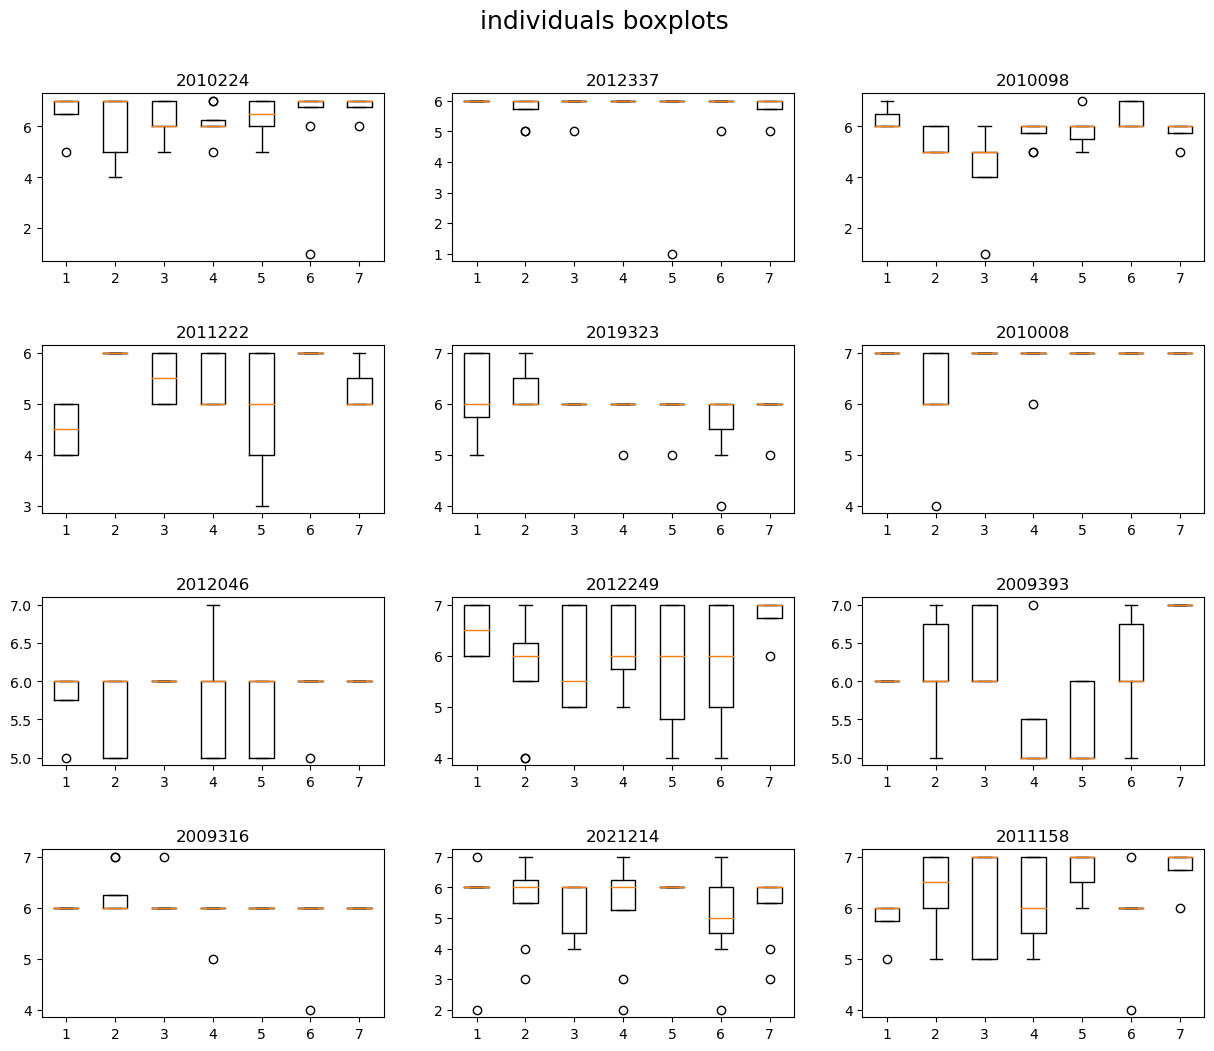

In [217]:
sub_list = random.sample(list(list_kmeans_G3), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df_patient['NumJourHarmonise'] = df_patient['NumJour'] % 8 + df_patient['NumJour'] // 8
    
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['NumJourHarmonise'] == signal_jour]['Craving'] for signal_jour in sorted(df['NumJourHarmonise'].unique())],
            labels=sorted(df['NumJourHarmonise'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()

**Conclusion :** Le clustering effectué ne semble pas refleter des types de profils. On peut essayer d'améliorer cela en ajoutant d'autres informations au dataset utilisé.

## 1.1 K-Means amélioré

In [218]:
# On récupère le df_clustering pour le compléter
df_clustering = df_clustering.drop(columns='Cluster')
df_clustering

1         2         3         4
2004003     1.875  1.545455  3.444444     3.875
2007006       1.0       2.0  1.333333  1.916667
2008254       6.0     5.125     5.125  6.181818
2008275  2.166667  2.454545  2.916667       2.4
2009144  1.909091  3.166667      3.75  4.666667
...           ...       ...       ...       ...
2022061  1.666667       1.8  1.777778  1.777778
2022071  2.928571  3.357143  3.642857  3.923077
2022073       5.5  4.857143  4.416667  3.833333
2022075  5.555556  6.615385  5.818182  6.307692
6402002  2.916667  3.416667  3.777778     3.125

[211 rows x 4 columns]

In [219]:
# On crée un nouveau dataset avec les colonnes que l'on veut ajouter
df8 = data_raw[['Age', 'Sexe', 'Addiction', ]].copy()
df8 = df8.dropna()

In [220]:
# On récupère uniquement une ligne par patient (les valeurs sont répétées pour chaque patient)
df8_groupby = df8.groupby('SubjectID').head(1).reset_index()
df8_groupby = df8_groupby.set_index('SubjectID')

In [221]:
# On ajoute les colonnes au df_clustering
df_clustering['Age'] = df8_groupby['Age'].values
df_clustering['Sexe'] = df8_groupby['Sexe'].values
df_clustering['Addiction'] = df8_groupby['Addiction'].values
df_clustering

1         2         3         4        Age  Sexe  Addiction
2004003     1.875  1.545455  3.444444     3.875  29.915068     1          5
2007006       1.0       2.0  1.333333  1.916667  42.175342     1          2
2008254       6.0     5.125     5.125  6.181818  47.224658     1         10
2008275  2.166667  2.454545  2.916667       2.4  28.268493     1          2
2009144  1.909091  3.166667      3.75  4.666667  41.334247     0          2
...           ...       ...       ...       ...        ...   ...        ...
2022061  1.666667       1.8  1.777778  1.777778  42.000000     1          2
2022071  2.928571  3.357143  3.642857  3.923077  49.000000     1          2
2022073       5.5  4.857143  4.416667  3.833333  53.000000     0         17
2022075  5.555556  6.615385  5.818182  6.307692  41.000000     1         17
6402002  2.916667  3.416667  3.777778     3.125  33.000000     0         17

[211 rows x 7 columns]

#### On ajoute des features représentant les pentes entre les points

In [222]:
df_clustering['p1'] = df_clustering['2'] / df_clustering['1']
df_clustering['p2'] = df_clustering['3'] / df_clustering['2']
df_clustering['p3'] = df_clustering['4'] / df_clustering['3']

In [223]:
df_clustering

1         2         3         4        Age  Sexe  Addiction  \
2004003     1.875  1.545455  3.444444     3.875  29.915068     1          5   
2007006       1.0       2.0  1.333333  1.916667  42.175342     1          2   
2008254       6.0     5.125     5.125  6.181818  47.224658     1         10   
2008275  2.166667  2.454545  2.916667       2.4  28.268493     1          2   
2009144  1.909091  3.166667      3.75  4.666667  41.334247     0          2   
...           ...       ...       ...       ...        ...   ...        ...   
2022061  1.666667       1.8  1.777778  1.777778  42.000000     1          2   
2022071  2.928571  3.357143  3.642857  3.923077  49.000000     1          2   
2022073       5.5  4.857143  4.416667  3.833333  53.000000     0         17   
2022075  5.555556  6.615385  5.818182  6.307692  41.000000     1         17   
6402002  2.916667  3.416667  3.777778     3.125  33.000000     0         17   

               p1        p2        p3  
2004003  0.824242  2.228758     1.125  
2007006       2.0  0.666667    1.4375  
2008254  0.854167       1.0  1.206208  
2008275  1.132867  1.188272  0.822857  
2009144   1.65873  1.184211  1.244444  
...           ...       ...       ...  
2022061      1.08  0.987654       1.0  
2022071  1.146341  1.085106  1.076923  
2022073  0.883117  0.909314  0.867925  
2022075  1.190769  0.879493  1.084135  
6402002  1.171429  1.105691  0.827206  

[211 rows x 10 columns]

#### On peut maintenant relancer notre K-Means :

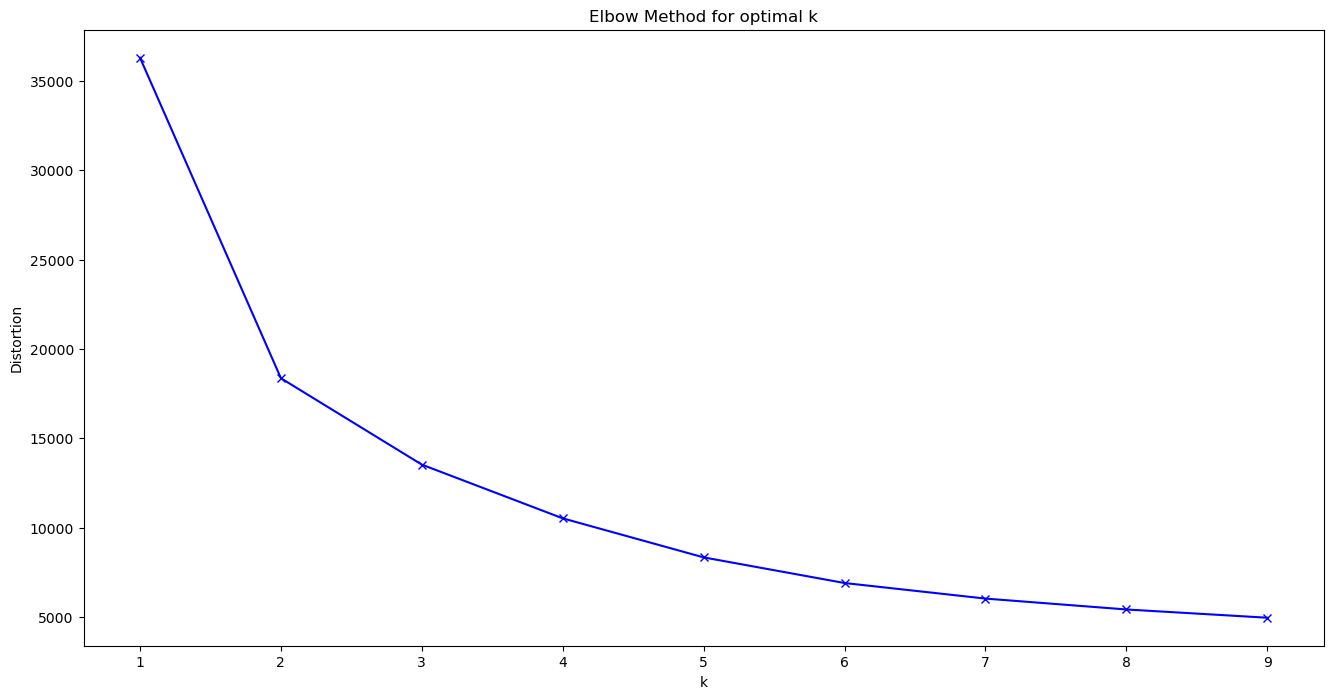

In [227]:
df_kmeans_ameliore = df_clustering
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_kmeans_ameliore)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

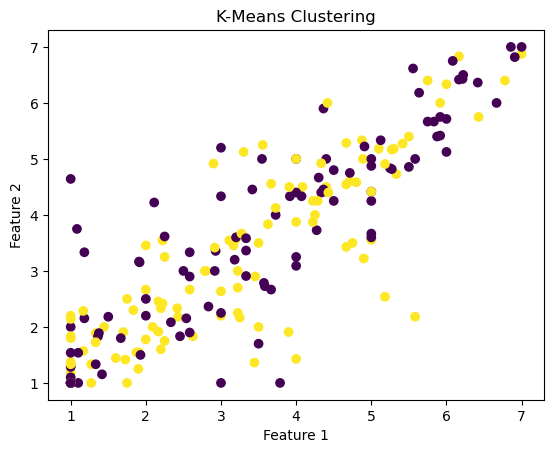

In [228]:
# Nombre de clusters que vous voulez créer
num_clusters = 2

# Créer le modèle K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuster le modèle aux données
kmeans.fit(df_kmeans_ameliore)

# Obtenir les étiquettes de cluster pour chaque patient
df_kmeans_ameliore['Cluster'] = kmeans.labels_

# Afficher les résultats
#print(df_kmeans[['Cluster']])

# Visualiser le résultat (2D, en utilisant les deux premières colonnes du dataset)
plt.scatter(df_kmeans_ameliore['1'], df_kmeans_ameliore['2'], c=df_kmeans_ameliore['Cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [229]:
import plotly.express as px

df_kmeans_ameliore = df_clustering

# Nombre de clusters que vous voulez créer
num_clusters = 2

# Créer le modèle K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuster le modèle aux données
kmeans.fit(df_kmeans_ameliore)

# Obtenir les étiquettes de cluster pour chaque patient
df_kmeans_ameliore['Cluster'] = kmeans.labels_

# Utiliser Plotly pour la visualisation en 3D
fig = px.scatter_3d(df_kmeans_ameliore, x='1', y='2', z='3', color='Cluster', size_max=18, opacity=0.8,
                    title='K-Means Clustering (3D)', labels={'1': 'Feature 1', '2': 'Feature 2', '3': 'Feature 3'})
fig.show()

In [230]:
df_kmeans_ameliore_G0 = df_kmeans_ameliore[df_kmeans_ameliore['Cluster'] == 0]
list_kmeans_ameliore_G0 = df_kmeans_ameliore_G0.index
list_kmeans_ameliore_G0

Index(['2007006', '2008254', '2009144', '2009152', '2009189', '2009221',
       '2009239', '2009241', '2009283', '2009297',
       ...
       '2021159', '2021168', '2021173', '2022016', '2022038', '2022051',
       '2022061', '2022071', '2022073', '2022075'],
      dtype='object', length=104)

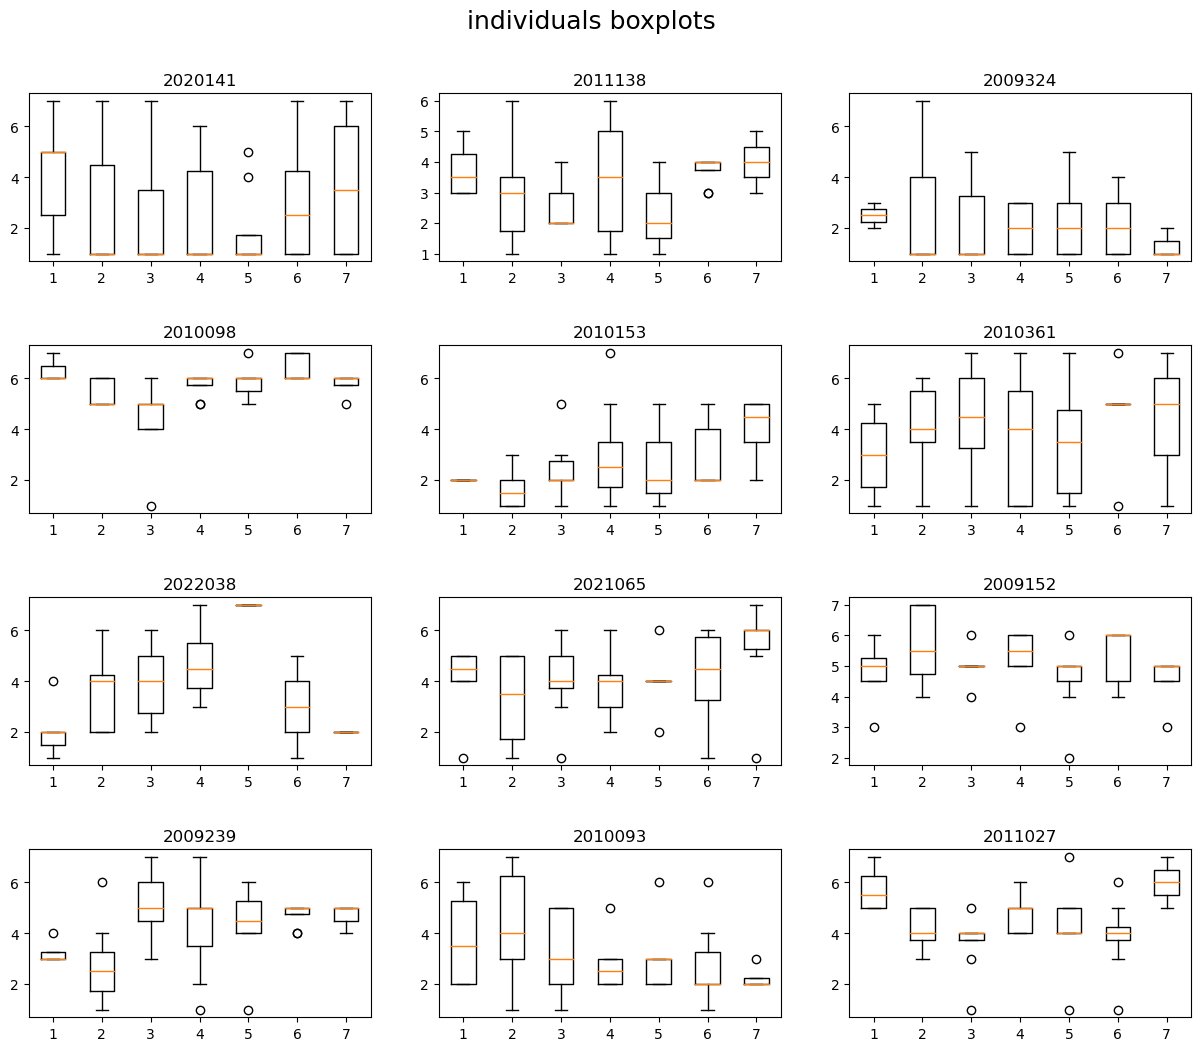

In [231]:
sub_list = random.sample(list(list_kmeans_ameliore_G0), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df_patient['NumJourHarmonise'] = df_patient['NumJour'] % 8 + df_patient['NumJour'] // 8
    
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['NumJourHarmonise'] == signal_jour]['Craving'] for signal_jour in sorted(df['NumJourHarmonise'].unique())],
            labels=sorted(df['NumJourHarmonise'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()

In [232]:
df_kmeans_ameliore_G1 = df_kmeans_ameliore[df_kmeans_ameliore['Cluster'] == 1]
list_kmeans_ameliore_G1 = df_kmeans_ameliore_G1.index
list_kmeans_ameliore_G1

Index(['2004003', '2008275', '2009155', '2009162', '2009195', '2009198',
       '2009200', '2009207', '2009208', '2009215',
       ...
       '2020193', '2021066', '2021151', '2021166', '2021193', '2021214',
       '2022027', '2022047', '2022053', '6402002'],
      dtype='object', length=107)

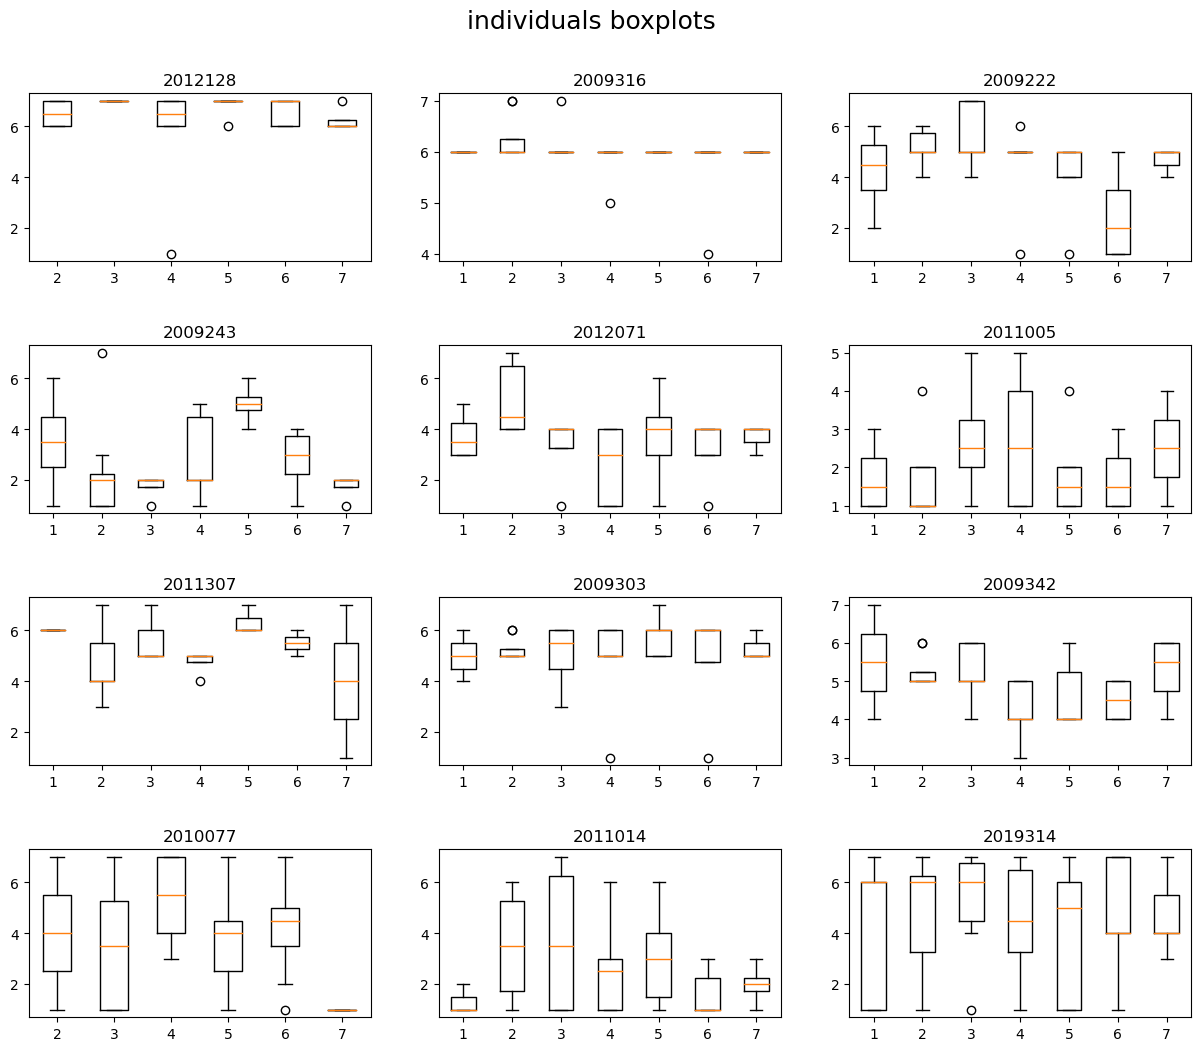

In [233]:
sub_list = random.sample(list(list_kmeans_ameliore_G1), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df_patient['NumJourHarmonise'] = df_patient['NumJour'] % 8 + df_patient['NumJour'] // 8
    
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['NumJourHarmonise'] == signal_jour]['Craving'] for signal_jour in sorted(df['NumJourHarmonise'].unique())],
            labels=sorted(df['NumJourHarmonise'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()

#### Essayons sans les facteurs 'Age', 'Sexe' et 'Addiction'

In [238]:
df_clustering_pente = df_clustering.drop(columns='Age')
df_clustering_pente = df_clustering_pente.drop(columns='Sexe')
df_clustering_pente = df_clustering_pente.drop(columns='Addiction')
df_clustering_pente = df_clustering_pente.drop(columns='Cluster')
df_clustering_pente

1         2         3         4        p1        p2        p3
2004003     1.875  1.545455  3.444444     3.875  0.824242  2.228758     1.125
2007006       1.0       2.0  1.333333  1.916667       2.0  0.666667    1.4375
2008254       6.0     5.125     5.125  6.181818  0.854167       1.0  1.206208
2008275  2.166667  2.454545  2.916667       2.4  1.132867  1.188272  0.822857
2009144  1.909091  3.166667      3.75  4.666667   1.65873  1.184211  1.244444
...           ...       ...       ...       ...       ...       ...       ...
2022061  1.666667       1.8  1.777778  1.777778      1.08  0.987654       1.0
2022071  2.928571  3.357143  3.642857  3.923077  1.146341  1.085106  1.076923
2022073       5.5  4.857143  4.416667  3.833333  0.883117  0.909314  0.867925
2022075  5.555556  6.615385  5.818182  6.307692  1.190769  0.879493  1.084135
6402002  2.916667  3.416667  3.777778     3.125  1.171429  1.105691  0.827206

[211 rows x 7 columns]

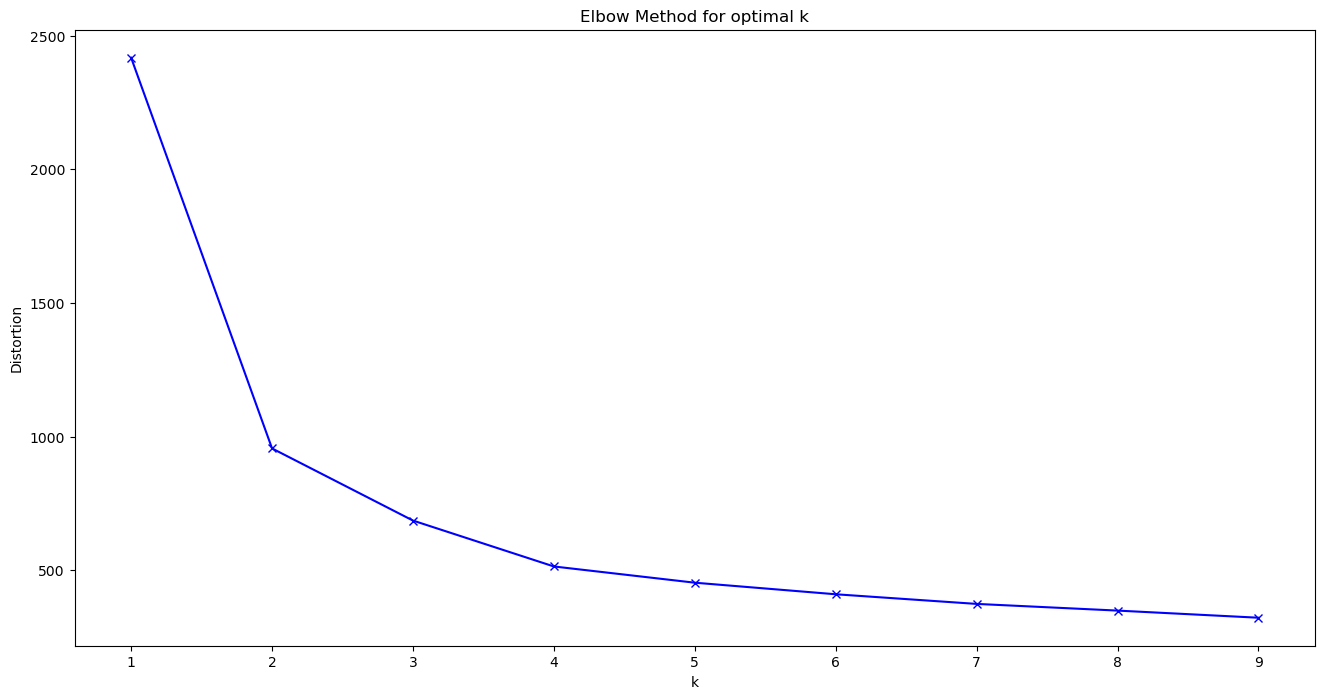

In [239]:
df_kmeans_ameliore = df_clustering_pente
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_kmeans_ameliore)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

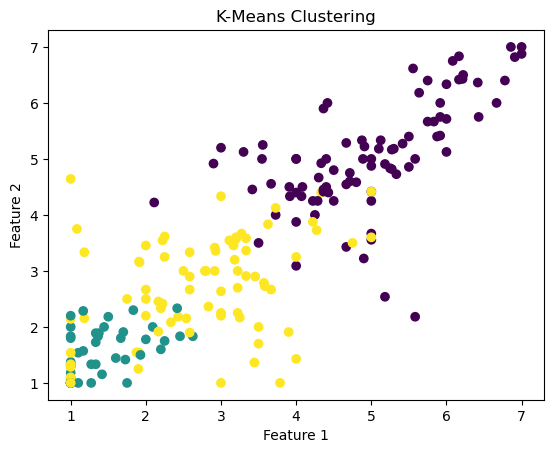

In [242]:
# Nombre de clusters que vous voulez créer
num_clusters = 3

# Créer le modèle K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuster le modèle aux données
kmeans.fit(df_kmeans_ameliore)

# Obtenir les étiquettes de cluster pour chaque patient
df_kmeans_ameliore['Cluster'] = kmeans.labels_

# Afficher les résultats
#print(df_kmeans[['Cluster']])

# Visualiser le résultat (2D, en utilisant les deux premières colonnes du dataset)
plt.scatter(df_kmeans_ameliore['1'], df_kmeans_ameliore['2'], c=df_kmeans_ameliore['Cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [243]:
import plotly.express as px

df_kmeans_ameliore = df_clustering_pente

# Nombre de clusters que vous voulez créer
num_clusters = 3

# Créer le modèle K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Ajuster le modèle aux données
kmeans.fit(df_kmeans_ameliore)

# Obtenir les étiquettes de cluster pour chaque patient
df_kmeans_ameliore['Cluster'] = kmeans.labels_

# Utiliser Plotly pour la visualisation en 3D
fig = px.scatter_3d(df_kmeans_ameliore, x='1', y='2', z='3', color='Cluster', size_max=18, opacity=0.8,
                    title='K-Means Clustering (3D)', labels={'1': 'Feature 1', '2': 'Feature 2', '3': 'Feature 3'})
fig.show()

In [244]:
df_kmeans_ameliore_G0 = df_kmeans_ameliore[df_kmeans_ameliore['Cluster'] == 0]
list_kmeans_ameliore_G0 = df_kmeans_ameliore_G0.index
list_kmeans_ameliore_G0

Index(['2008254', '2009152', '2009162', '2009189', '2009198', '2009207',
       '2009208', '2009215', '2009222', '2009239', '2009241', '2009250',
       '2009292', '2009297', '2009303', '2009316', '2009342', '2009345',
       '2009349', '2009362', '2009366', '2009381', '2009390', '2009392',
       '2009393', '2010008', '2010024', '2010031', '2010039', '2010047',
       '2010098', '2010105', '2010204', '2010212', '2010224', '2010284',
       '2010300', '2010321', '2010329', '2011027', '2011030', '2011032',
       '2011046', '2011068', '2011133', '2011158', '2011169', '2011222',
       '2011307', '2012046', '2012054', '2012061', '2012114', '2012128',
       '2012151', '2012152', '2012165', '2012241', '2012249', '2012272',
       '2012311', '2012337', '2013084', '2013100', '2013114', '2013200',
       '2013221', '2018296', '2019314', '2019316', '2019323', '2020036',
       '2020085', '2020101', '2020120', '2020178', '2020193', '2021065',
       '2021066', '2021084', '2021096', '2021107', 

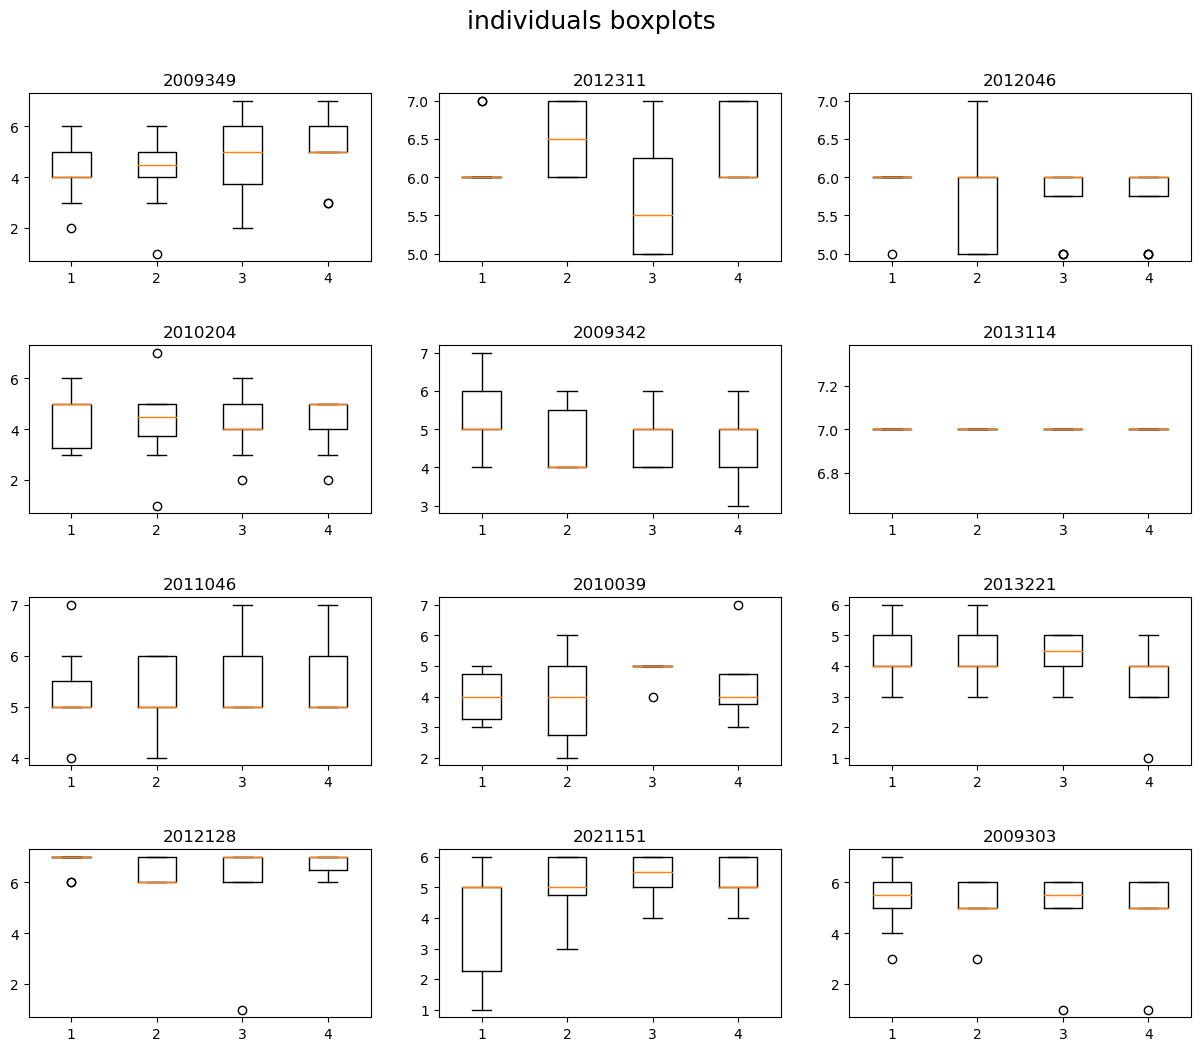

In [248]:
sub_list = random.sample(list(list_kmeans_ameliore_G0), 12)

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("individuals boxplots", fontsize=18, y=0.95)

# loop through tickers and axes
for patient, ax in zip(sub_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_patient = result[patient]
    df = pd.DataFrame(df_patient)
    
    # Créer un box plot
    ax.boxplot([df[df['SignalJour'] == signal_jour]['Craving'] for signal_jour in sorted(df['SignalJour'].unique())],
            labels=sorted(df['SignalJour'].unique()))

    # chart formatting
    ax.set_title(patient.upper())
    ax.set_xlabel("")

plt.show()